# FDS Project

### Loading Libraries as specified in requirements.txt

In [194]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec  # Add this import
import seaborn as sns
import statsmodels.formula.api as smf
import csv 
import sklearn.preprocessing
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler



# PCA, K-Nearest Neighbours 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

# Randomness,sampling simulations
from scipy.stats import uniform, norm, expon

# Bootstrap
import statsmodels.formula.api as smf # Regression library
from scipy.stats import norm # Object to with member functions to do with normal distributions

# logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

### Loading datasets and Cleaning

In [124]:
# Categories cleaning 
categories_loc = os.path.join(os.getcwd(), 'steam-insights', 'categories.csv')
categories = pd.read_csv(categories_loc)

categories['category'] = categories['category'].astype('string')
categories= categories.groupby('app_id')['category'].apply(list).reset_index()
categories.head()

app_id                                           category
0      10  [Family Sharing, Multi-player, Online PvP, PvP...
1      20  [Family Sharing, Multi-player, Online PvP, PvP...
2      30  [Family Sharing, Multi-player, Valve Anti-Chea...
3      40  [Family Sharing, Multi-player, Online PvP, PvP...
4      50  [Family Sharing, Multi-player, Remote Play Tog...

In [125]:
# Reviews cleaning 

reviews_loc = os.path.join(os.getcwd(), 'steam-insights', 'reviews.csv')
reviews = pd.read_csv(reviews_loc, 
                     na_values=['\\N'],  # Treat \N as NULL
                     keep_default_na=True,
                     on_bad_lines='skip')

#print("Missing values in reviews DataFrame:", reviews.isna().sum())

# Drop columns with many na's
reviews = reviews.drop(columns=['metacritic_score', 'reviews', 'recommendations', 
                              'steamspy_score_rank', 'steamspy_positive', 
                              'steamspy_negative'], axis=1)

reviews = reviews.dropna(subset=['steamspy_user_score','review_score'])

reviews['app_id'] = reviews['app_id'].astype(int)
reviews['review_score'] = reviews['review_score'].astype(int)
reviews['review_score_description'] = reviews['review_score_description'].astype('string')
reviews['steamspy_user_score'] = pd.to_numeric(reviews['steamspy_user_score'], errors='coerce')
reviews = reviews.dropna(subset=['steamspy_user_score'])

reviews.head()



C:\Users\Georg\AppData\Local\Temp\ipykernel_78184\230650386.py:4: DtypeWarning: Columns (0,1,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv(reviews_loc,


app_id  review_score review_score_description  positive  negative  \
0      10             9  Overwhelmingly Positive  235403.0    6207.0   
1      20             8            Very Positive    7315.0    1094.0   
2      30             8            Very Positive    6249.0     672.0   
3      40             8            Very Positive    2542.0     524.0   
4      50             9  Overwhelmingly Positive   22263.0    1111.0   

      total  steamspy_user_score  
0  241610.0                  0.0  
1    8409.0                  0.0  
2    6921.0                  0.0  
3    3066.0                  0.0  
4   23374.0                  0.0

In [126]:
# steamspy cleaning 

steamspy_loc = os.path.join(os.getcwd(), 'steam-insights', 'steamspy_insights.csv')
steamspy = pd.read_csv(steamspy_loc, on_bad_lines='skip', na_values=[r'\N'])  # Ensure \N is treated as NA
steamspy = steamspy.dropna(subset=['developer','genres','publisher','languages'])
steamspy['developer'] = steamspy['developer'].astype('string')
steamspy['publisher'] = steamspy['publisher'].astype('string')
#steamspy['languages'] = steamspy['languages'].astype('string')
steamspy['genres'] = steamspy['genres'].astype('string')

# Extract and calculate average owners from the range
def extract_owners_average(owners_range):
    try:
        # Extract the numbers from the range (format like "10,000,000 .. 20,000,000")
        parts = owners_range.replace(',', '').split('..')
        min_owners = int(parts[0].strip())
        max_owners = int(parts[1].strip())
        return (min_owners + max_owners) / 2
    except (ValueError, AttributeError, IndexError):
        return None

# Apply the function to create a new column
steamspy['owners_average'] = steamspy['owners_range'].apply(extract_owners_average)

steamspy.head()


app_id         developer publisher              owners_range  \
0      10             Valve     Valve  10,000,000 .. 20,000,000   
1      20             Valve     Valve   5,000,000 .. 10,000,000   
2      30             Valve     Valve   5,000,000 .. 10,000,000   
3      40             Valve     Valve   5,000,000 .. 10,000,000   
4      50  Gearbox Software     Valve    2,000,000 .. 5,000,000   

   concurrent_users_yesterday  playtime_average_forever  \
0                       11457                         0   
1                          52                         0   
2                          82                         0   
3                           6                         0   
4                          99                         0   

   playtime_average_2weeks  playtime_median_forever  playtime_median_2weeks  \
0                        0                        0                       0   
1                        0                        0                       0   
2                        0                        0                       0   
3                        0                        0                       0   
4                        0                        0                       0   

   price  initial_price  discount  \
0  999.0          999.0       0.0   
1  499.0          499.0       0.0   
2  499.0          499.0       0.0   
3  499.0          499.0       0.0   
4  499.0          499.0       0.0   

                                           languages  genres  owners_average  
0  English, French, German, Italian, Spanish - Sp...  Action      15000000.0  
1  English, French, German, Italian, Spanish - Sp...  Action       7500000.0  
2  English, French, German, Italian, Spanish - Spain  Action       7500000.0  
3  English, French, German, Italian, Spanish - Sp...  Action       7500000.0  
4                    English, French, German, Korean  Action       3500000.0

In [127]:
# Games cleaning 

games_loc = os.path.join(os.getcwd(), 'steam-insights', 'games.csv')
games = pd.read_csv(
    games_loc, 
    encoding='utf-8',
    escapechar='\\',  # Handle escape characters
    quotechar='"',    # Specify quote character
    on_bad_lines='skip'
)


games['release_date'] = pd.to_datetime(games['release_date'], format='%Y-%m-%d', errors='coerce')
games['name'] = games['name'].astype('string')
games['type'] = games['type'].astype('string')

# Convert to string to ensure we're working with strings
games['price_overview'] = games['price_overview'].astype(str)

# Extract final price
games['price_final'] = games['price_overview'].str.extract(r'"final":\s*(\d+)').astype(float) / 100

# Extract initial price
games['price_initial'] = games['price_overview'].str.extract(r'"initial":\s*(\d+)').astype(float) / 100

# Extract currency
games['currency'] = games['price_overview'].str.extract(r'"currency":\s*"([^"]+)')

games['currency'] = games['currency'].astype('string')



games = games.drop(columns=['price_overview', 'languages'])

paid_games = games[(games['type'] == 'game') & (games['is_free'] == 0)]
paid_games = paid_games.dropna(subset=['price_final','release_date'])

free_games = games[(games['type'] == 'game') & (games['is_free']==1)]
free_games = free_games.drop(columns=['price_final','price_initial','currency'])
free_games = free_games.dropna(subset=['release_date'])

demos = games[games['type'] != 'game']
demos = demos.drop(columns=['price_final','price_initial','currency'])
demos = demos.dropna(subset=['release_date'])


In [128]:
# genres cleaning
genres_loc = os.path.join(os.getcwd(), 'steam-insights', 'genres.csv')
genres = pd.read_csv(genres_loc)

genres['genre'] = genres['genre'].astype('string')

genres.head()


app_id   genre
0      10  Action
1      20  Action
2      30  Action
3      40  Action
4      50  Action

In [129]:
# tags cleaning 
tags_loc = os.path.join(os.getcwd(), 'steam-insights', 'tags.csv')
tags = pd.read_csv(tags_loc)

tags['tag'] = tags['tag'].astype('string')
tags= tags.groupby('app_id')['tag'].apply(list).reset_index()

tags.head()

app_id                                                tag
0      10  [1980s, 1990's, Action, Assassin, Classic, Com...
1      20  [1990's, Action, Class-Based, Classic, Co-op, ...
2      30  [Action, Class-Based, Classic, Co-op, Difficul...
3      40  [1990's, Action, Arena Shooter, Classic, Co-op...
4      50  [1990's, Action, Adventure, Aliens, Atmospheri...

### Filtered and merged paid games

In [154]:
# Paid games dataset 
filtered_paid_games = paid_games.copy()
filtered_paid_games = filtered_paid_games.merge(genres, on='app_id', how='inner')
filtered_paid_games = filtered_paid_games[(filtered_paid_games['genre'] != 'Audio Production') & 
                    (filtered_paid_games['genre'] != 'Accounting') &
                    (filtered_paid_games['genre'] != 'Utilities') & 
                    (filtered_paid_games['genre'] != 'Video Production') &
                    (filtered_paid_games['genre'] != 'Design & Illustration') & 
                    (filtered_paid_games['genre'] != 'Game Development') &
                    (filtered_paid_games['genre'] != 'Web Publishing') & 
                    (filtered_paid_games['genre'] != 'Software Training') &
                    (filtered_paid_games['genre'] != 'Animation & Modeling') & 
                    (filtered_paid_games['genre'] != 'Photo Editing') &
                    (filtered_paid_games['genre'] != 'Documentary') &
                    (filtered_paid_games['genre'] != 'Education') &
                    (filtered_paid_games['genre'] != 'Episodic') &
                    (filtered_paid_games['genre'] != 'Movie') &
                    (filtered_paid_games['genre'] != 'Short') &
                    (filtered_paid_games['genre'] != 'Tutorial') &
                    (filtered_paid_games['genre'] != '360 Video') &
                    (filtered_paid_games['genre'] != 'Free To Play')]
filtered_paid_games['release_year'] = filtered_paid_games['release_date'].dt.year

# Merge on Positive Reviews
filtered_paid_games = filtered_paid_games.merge(reviews[['app_id', 'review_score', 'review_score_description', 'positive', 'negative', 'total']], on='app_id', how='inner')
# Avoid duplication of Games
filtered_paid_games = filtered_paid_games.groupby(['app_id', 'name', 'release_date', 'is_free',
                                               'type', 'price_final', 'price_initial',
                                               'currency', 'release_year', 'positive', 
                                               'review_score', 'review_score_description', 
                                               'negative', 'total'])['genre'].agg(list).reset_index()
# Merge on concurrent players 
filtered_paid_games = filtered_paid_games.merge(steamspy[['app_id','concurrent_users_yesterday','owners_average']], on='app_id', how='inner')
# Merge on tags 
filtered_paid_games = filtered_paid_games.merge(tags[['app_id','tag']], on='app_id', how='inner')
# Merge on Categories 
filtered_paid_games = filtered_paid_games.merge(categories[['app_id','category']], on='app_id', how='inner')
# Extract year 
filtered_paid_games['release_year'] = filtered_paid_games['release_date'].dt.year
# Calculate the price difference from initial release to current 
filtered_paid_games['price_difference'] = filtered_paid_games['price_initial']-filtered_paid_games['price_final']

# Drop columns not needed 
filtered_paid_games.drop(columns=['is_free','type'], inplace=True)

filtered_paid_games.head()

app_id                       name release_date  price_final  price_initial  \
0      10             Counter-Strike   2000-11-01         8.19           8.19   
1      20      Team Fortress Classic   1999-04-01         4.99           4.99   
2      30              Day of Defeat   2003-05-01         4.99           4.99   
3      40         Deathmatch Classic   2001-06-01         4.99           4.99   
4      50  Half-Life: Opposing Force   1999-11-01         4.99           4.99   

  currency  release_year  positive  review_score review_score_description  \
0      EUR          2000  235403.0             9  Overwhelmingly Positive   
1      EUR          1999    7315.0             8            Very Positive   
2      EUR          2003    6249.0             8            Very Positive   
3      EUR          2001    2542.0             8            Very Positive   
4      EUR          1999   22263.0             9  Overwhelmingly Positive   

   negative     total     genre  concurrent_users_yesterday  owners_average  \
0    6207.0  241610.0  [Action]                       11457      15000000.0   
1    1094.0    8409.0  [Action]                          52       7500000.0   
2     672.0    6921.0  [Action]                          82       7500000.0   
3     524.0    3066.0  [Action]                           6       7500000.0   
4    1111.0   23374.0  [Action]                          99       3500000.0   

                                                 tag  \
0  [1980s, 1990's, Action, Assassin, Classic, Com...   
1  [1990's, Action, Class-Based, Classic, Co-op, ...   
2  [Action, Class-Based, Classic, Co-op, Difficul...   
3  [1990's, Action, Arena Shooter, Classic, Co-op...   
4  [1990's, Action, Adventure, Aliens, Atmospheri...   

                                            category  price_difference  
0  [Family Sharing, Multi-player, Online PvP, PvP...               0.0  
1  [Family Sharing, Multi-player, Online PvP, PvP...               0.0  
2  [Family Sharing, Multi-player, Valve Anti-Chea...               0.0  
3  [Family Sharing, Multi-player, Online PvP, PvP...               0.0  
4  [Family Sharing, Multi-player, Remote Play Tog...               0.0

### Filtered and merged free games

In [152]:
# Free games dataset 
filtered_free_games = free_games.copy()
filtered_free_games = filtered_free_games.merge(genres, on='app_id', how='inner')
filtered_free_games = filtered_free_games[(filtered_free_games['genre'] != 'Audio Production') & 
          (filtered_free_games['genre'] != 'Accounting') &
          (filtered_free_games['genre'] != 'Utilities') & 
          (filtered_free_games['genre'] != 'Video Production') &
          (filtered_free_games['genre'] != 'Design & Illustration') & 
          (filtered_free_games['genre'] != 'Game Development') &
          (filtered_free_games['genre'] != 'Web Publishing') & 
          (filtered_free_games['genre'] != 'Software Training') &
          (filtered_free_games['genre'] != 'Animation & Modeling') & 
          (filtered_free_games['genre'] != 'Photo Editing') &
          (filtered_free_games['genre'] != 'Documentary') &
          (filtered_free_games['genre'] != 'Education') &
          (filtered_free_games['genre'] != 'Episodic') &
          (filtered_free_games['genre'] != 'Movie') &
          (filtered_free_games['genre'] != 'Short') &
          (filtered_free_games['genre'] != 'Tutorial') &
          (filtered_free_games['genre'] != '360 Video') &
          (filtered_free_games['genre'] != 'Free To Play')]
filtered_free_games['release_year'] = filtered_free_games['release_date'].dt.year

# Merge on Positive Reviews
filtered_free_games = filtered_free_games.merge(reviews[['app_id', 'review_score', 'review_score_description', 'positive', 'negative', 'total']], on='app_id', how='inner')
# Avoid duplication of Games
filtered_free_games = filtered_free_games.groupby(['app_id', 'name', 'release_date', 'is_free',
                         'type', 'release_year', 'positive', 
                         'review_score', 'review_score_description', 
                         'negative', 'total'])['genre'].agg(list).reset_index()
# Merge on concurrent players 
filtered_free_games = filtered_free_games.merge(steamspy[['app_id','concurrent_users_yesterday','owners_average']], on='app_id', how='inner')
# Merge on tags 
filtered_free_games = filtered_free_games.merge(tags[['app_id','tag']], on='app_id', how='inner')
# Merge on Categories 
filtered_free_games = filtered_free_games.merge(categories[['app_id','category']], on='app_id', how='inner')
# Extract year 
filtered_free_games['release_year'] = filtered_free_games['release_date'].dt.year
# Drop columns not needed 
filtered_free_games.drop(columns=['is_free','type'], inplace=True)


filtered_free_games.head()

app_id                 name release_date  release_year  positive  \
0     440      Team Fortress 2   2007-10-10          2007  990978.0   
1     630          Alien Swarm   2010-07-19          2010   20019.0   
2    3483       Peggle Extreme   2007-09-11          2007    2069.0   
3    4900        Zen of Sudoku   2006-12-14          2006     280.0   
4    6370  Bloodline Champions   2011-10-28          2011    1441.0   

   review_score review_score_description  negative      total  \
0             8            Very Positive  130730.0  1121708.0   
1             8            Very Positive    1089.0    21108.0   
2             8            Very Positive     120.0     2189.0   
3             8            Very Positive      33.0      313.0   
4             8            Very Positive     246.0     1687.0   

                             genre  concurrent_users_yesterday  \
0                         [Action]                       59701   
1                         [Action]                          16   
2                         [Casual]                          21   
3                  [Casual, Indie]                          11   
4  [Action, Massively Multiplayer]                           3   

   owners_average                                                tag  \
0      75000000.0  [Action, Cartoon, Cartoony, Class-Based, Co-op...   
1       3500000.0  [Action, Adventure, Aliens, Class-Based, Co-op...   
2        350000.0  [2D, Action, Arcade, Casual, Classic, Free to ...   
3         35000.0  [Casual, Free to Play, Indie, Puzzle, Relaxing...   
4        750000.0  [Action, Competitive, Fast-Paced, Free to Play...   

                                            category  
0  [Captions available, Commentary available, Cro...  
1  [Captions available, Co-op, Includes level edi...  
2  [Remote Play on Phone, Remote Play on Tablet, ...  
3                                    [Single-player]  
4                 [MMO, Multi-player, Single-player]

# Correlation and PCA

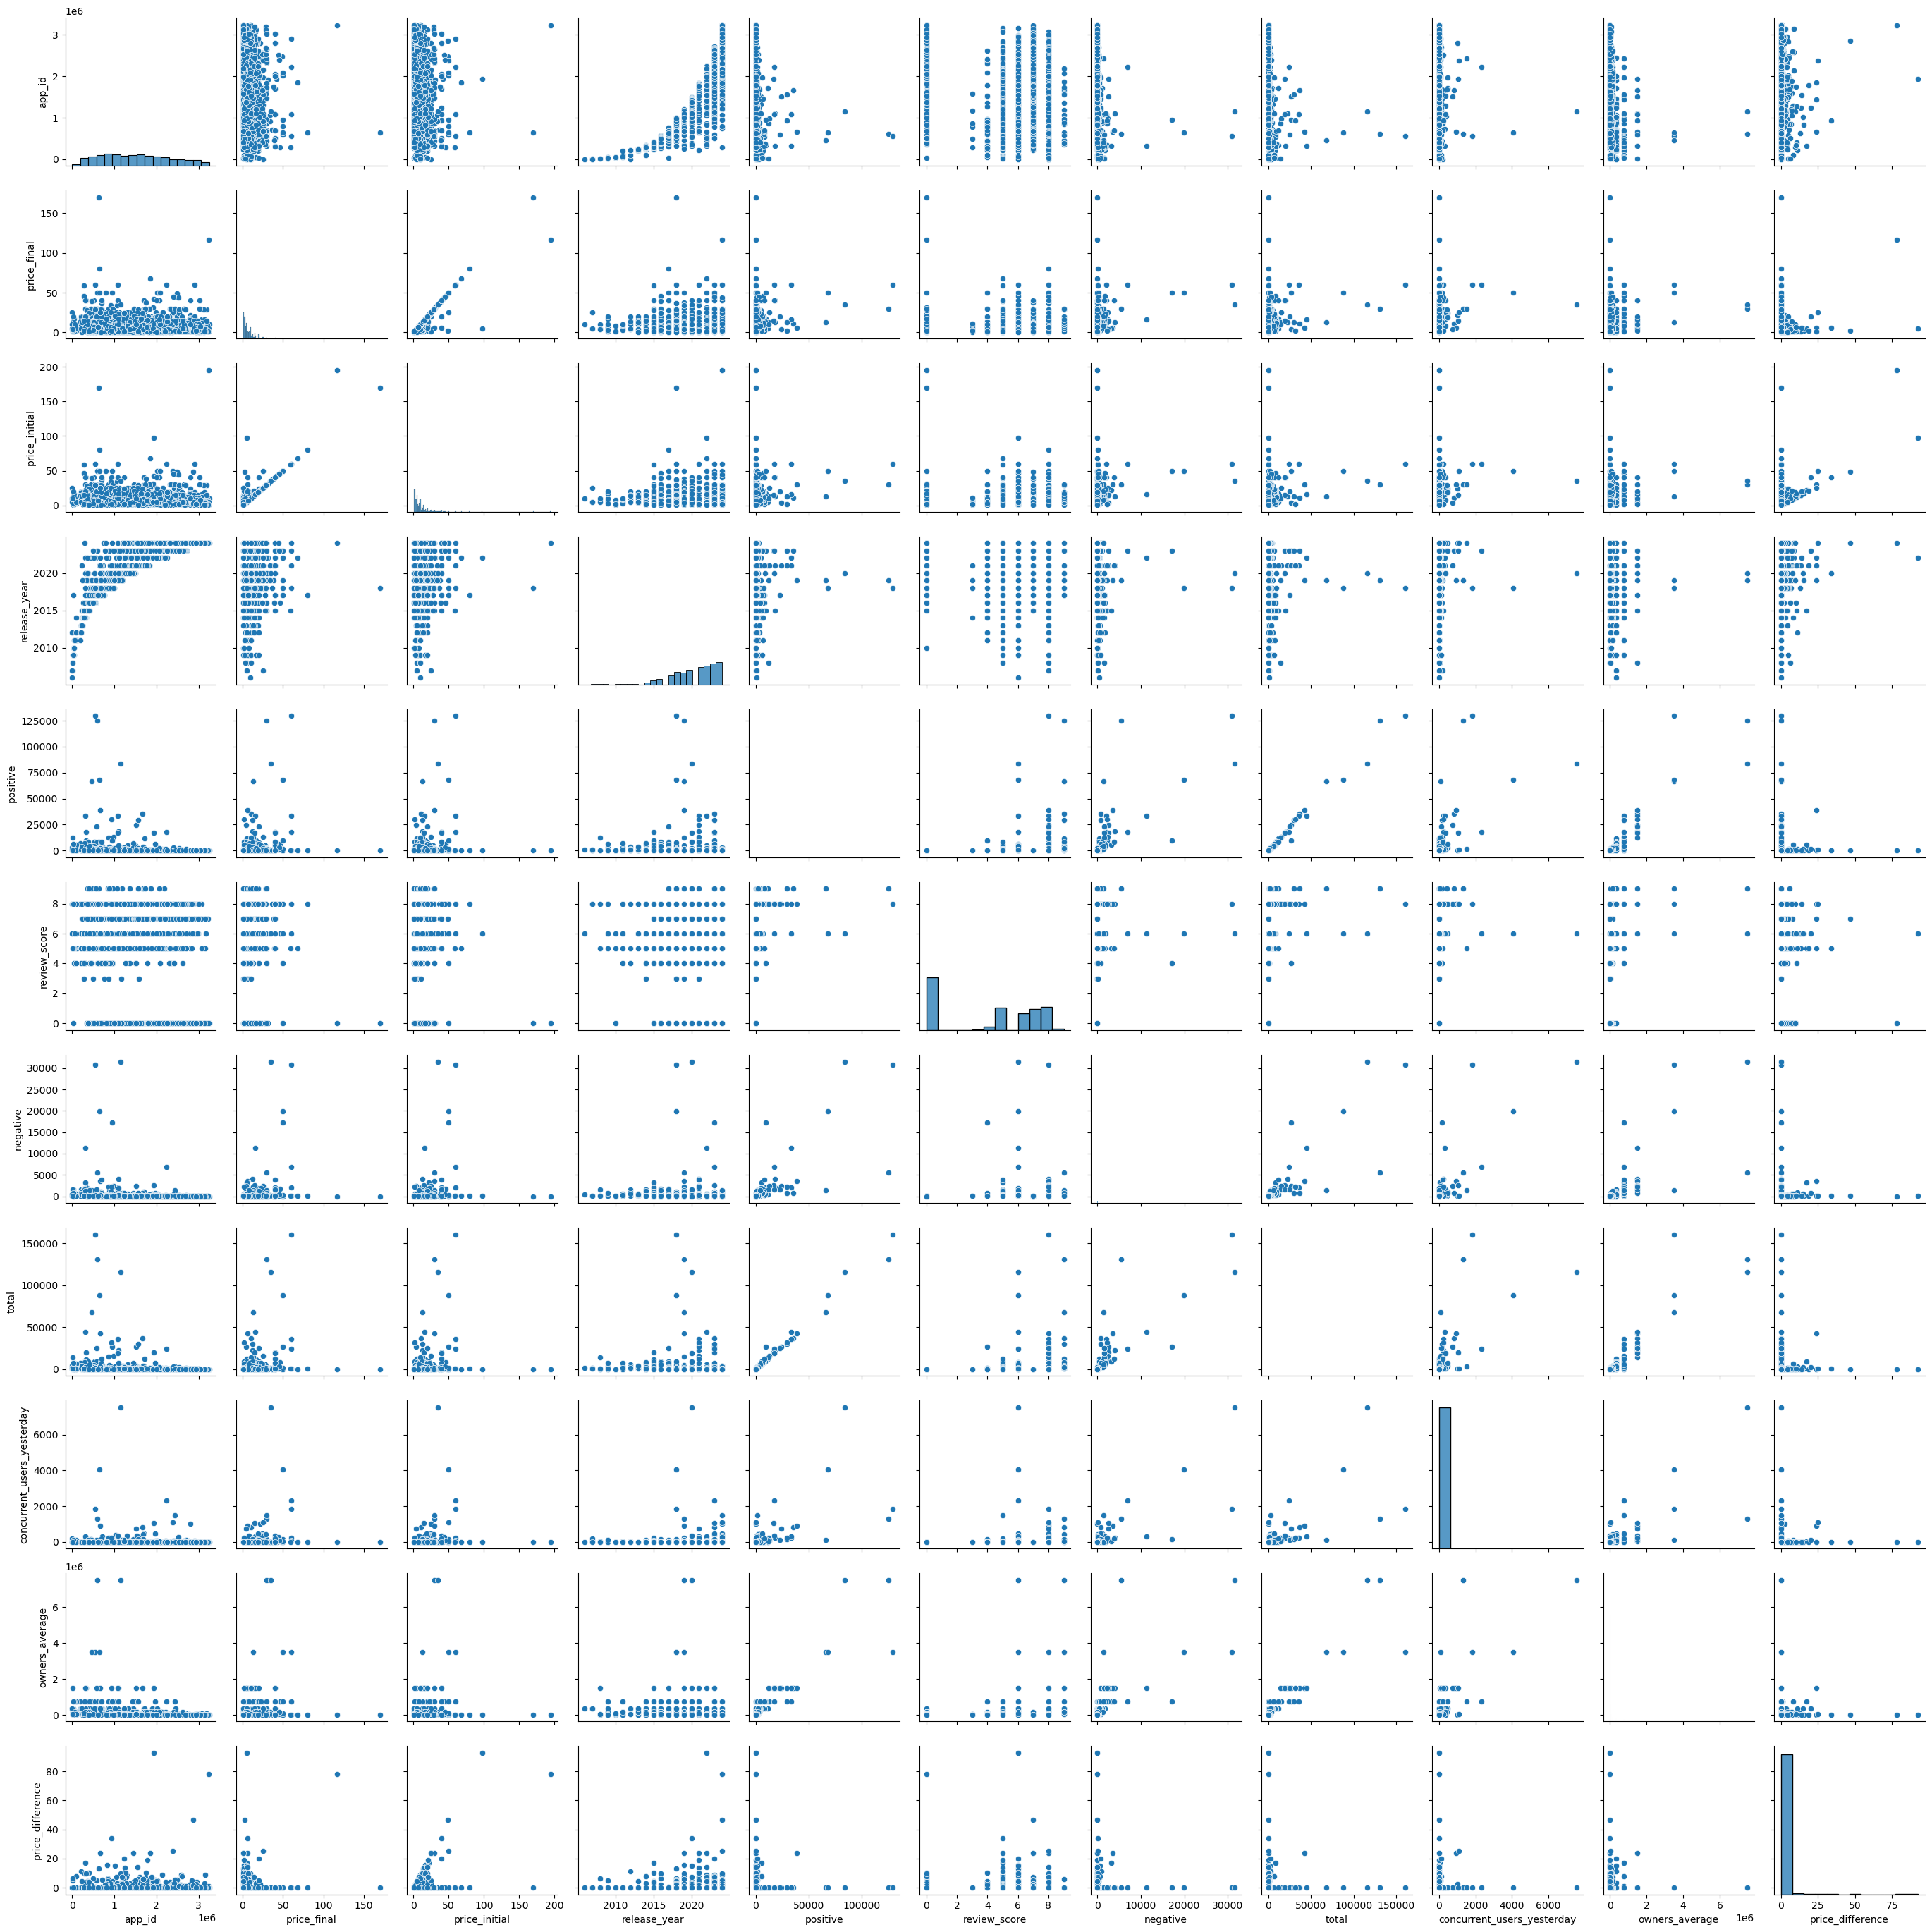

In [155]:
pairplot_data = filtered_paid_games[['app_id','price_final', 'price_initial', 'release_year', 'positive', 'review_score', 'negative', 'total', 'concurrent_users_yesterday', 'owners_average', 'price_difference']]
sampled_data = pairplot_data.sample(n=2000, random_state=42)

# Create the pairplot
pairplot = sns.pairplot(sampled_data)
plt.tight_layout()
plt.show()

### Scree Plot adn transformation - Figure out the optimal number of principle components 

TypeError: 'Series' object is not callable

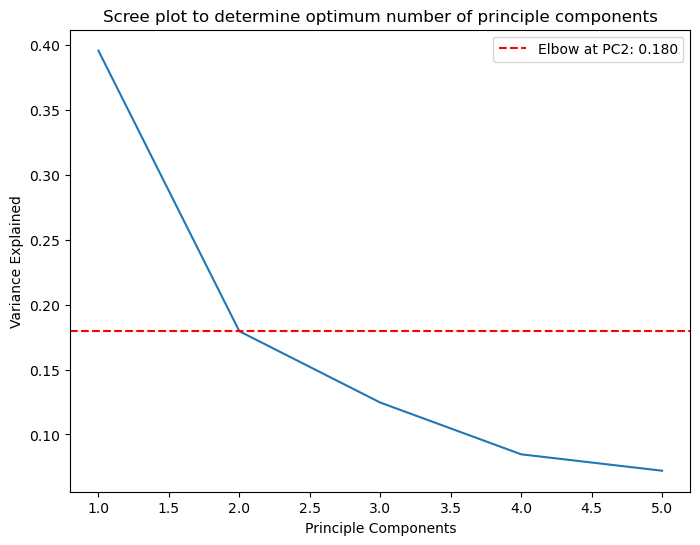

In [156]:
from sklearn.preprocessing import QuantileTransformer

# Standardize 
scaler = StandardScaler()

# Use copy of data frame and standardize the data 
pca_data = pairplot_data.copy()
# QuantileTransformer 
quantile_transformer = QuantileTransformer(output_distribution='normal')
# Transform with QuantileTransformer
transformed_data = quantile_transformer.fit_transform(pca_data)

# Then standardize the transformed data
scaled_pca_data = pd.DataFrame(scaler.fit_transform(transformed_data), columns=pca_data.columns)

# Fit PCA on the scaled, transformed data
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(scaled_pca_data)

# Scree Plot 
PC_values = np.arange(pca.n_components_) + 1 # 1 based component indexing 
plt.figure(figsize=(8,6))
sns.lineplot(x=PC_values, y=pca.explained_variance_ratio_)

# Red Dashed line to signify elbow 
plt.axhline(y=pca.explained_variance_ratio_[1], color='red', linestyle='--', label=f'Elbow at PC2: {pca.explained_variance_ratio_[1]:.3f}')

plt.legend()

plt.title("Scree plot to determine optimum number of principle components")
plt.xlabel("Principle Components")
plt.ylabel("Variance Explained")

for i in range(1, len(pca.explained_variance_ratio_)+1):
  print("Principal Component "+ str(i) + ": "+str(pca.explained_variance_ratio_[i-1]))


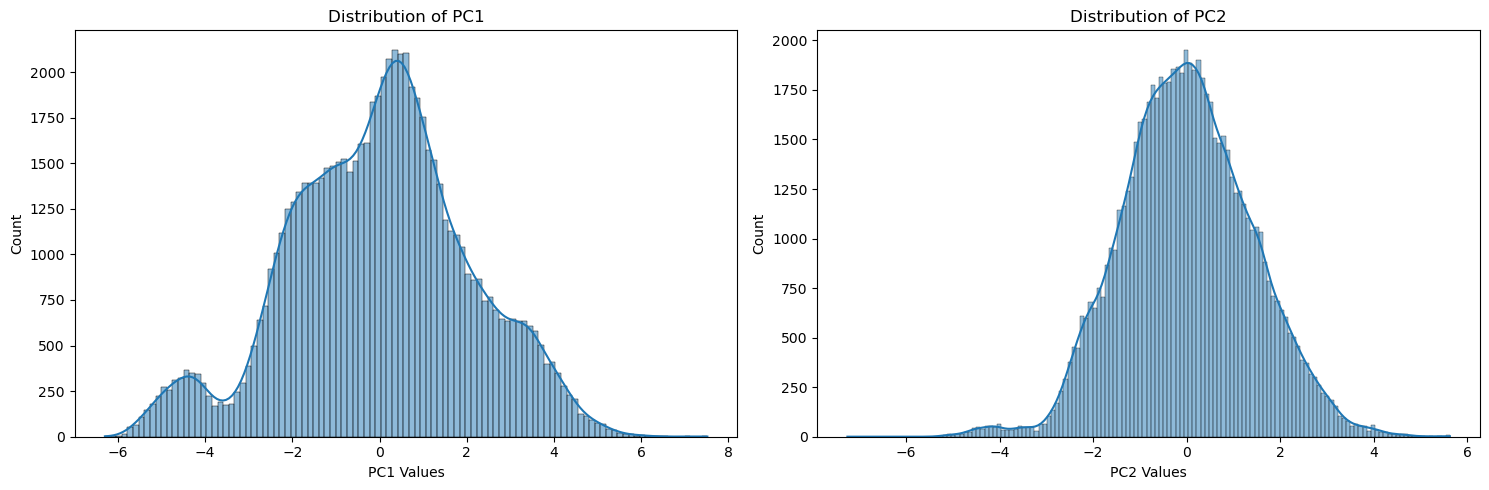

In [148]:
# Standardize 
scaler = StandardScaler()

# Use copy of data frame and standardize the data 
pca_data = pairplot_data.copy()
# QuantileTransformer 
quantile_transformer = QuantileTransformer(output_distribution='normal')
# Transform with QuantileTransformer
transformed_data = quantile_transformer.fit_transform(pca_data)

# Then standardize the transformed data
scaled_pca_data = pd.DataFrame(scaler.fit_transform(transformed_data), columns=pca_data.columns)

# Fit PCA on the scaled, transformed data
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(scaled_pca_data)

pca_df = pd.DataFrame(data=pca_fit, columns=['PC1', 'PC2'], index=pairplot_data.index)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# PC1 distribution
sns.histplot(pca_df['PC1'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of PC1')
axes[0].set_xlabel('PC1 Values')

# PC2 distribution
sns.histplot(pca_df['PC2'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of PC2')
axes[1].set_xlabel('PC2 Values')


plt.tight_layout()
plt.show()


### Bootstrapping and PCA Distribution 

In [ ]:
# Set up the plot
plt.figure(figsize=(12, 10))

# Create and plot multiple bootstrap samples
for i in range(3):  # n_samples=3
    boot_sample = resample(pca_df, n_samples=2000, random_state=i*10)
    plt.scatter(
        boot_sample['PC1'], 
        boot_sample['PC2'],
        color='blue',  # Same color for all bootstrap samples
        alpha=0.3,
        s=20,
        label=f'Bootstrap {i+1}'
    )

# Component Loadings 
component_loadings = pd.DataFrame(
    pca.components_[:2, :].T,  # Take only first 2 components (rows)
    columns=['PC1', 'PC2'],
    index=pairplot_data.columns
)
print("\nComponent loadings:")
print(component_loadings)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add origin lines
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# Add labels with variance explained
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)', fontsize=12)

# Add title
plt.title('PCA Results with Multiple Bootstrap Samples', fontsize=16)

# Set axis limits
plt.xlim(-12, 12)
plt.ylim(-12, 12)

# Add legend
plt.legend(loc='upper right')

# Add annotation for total variance explained
total_var = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]
plt.annotate(f'Total variance explained: {total_var:.2%}',
             xy=(0.02, 0.98),
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

TypeError: 'Series' object is not callable

<Figure size 1200x1000 with 0 Axes>

C:\Users\Georg\AppData\Local\Temp\ipykernel_78184\154717556.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')  # Use a color map with distinct colors


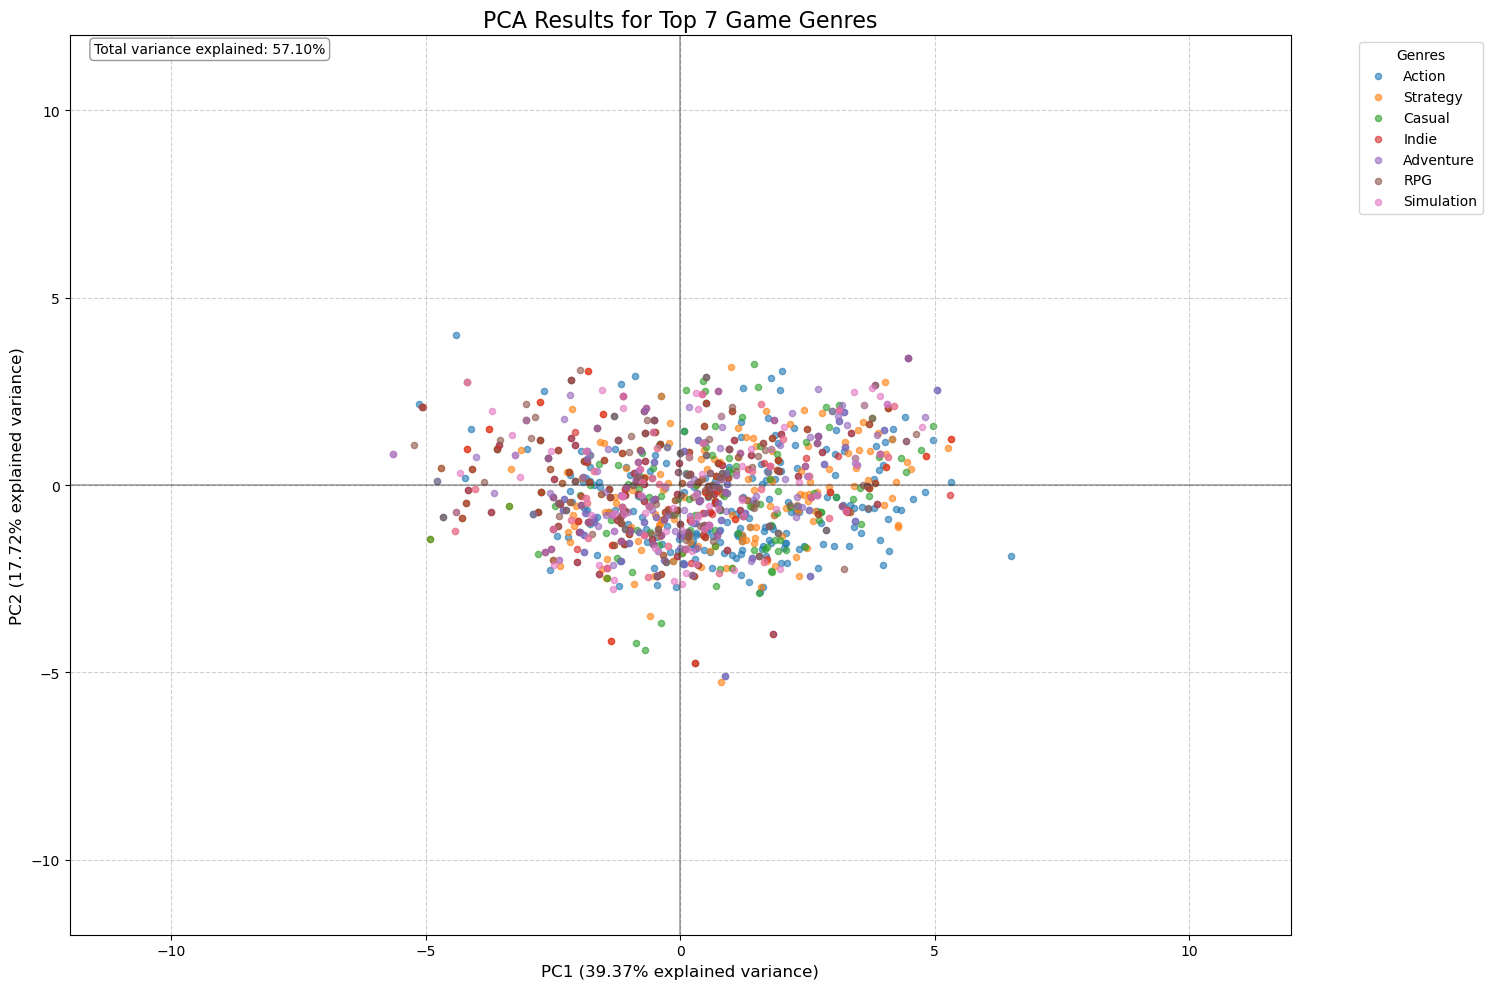


Top 7 Genre Distribution:
genre
Action        370
Strategy      234
Casual        186
Indie         182
Adventure     165
RPG           110
Simulation    110
Name: count, dtype: int64


In [138]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Ensure 'genre' column is a list and explode it
pca_df_exploded = pca_df.copy()
pca_df_exploded = pca_df_exploded.merge(
    filtered_paid_games[['app_id', 'genre']], 
    left_index=True, 
    right_on='app_id'
)

pca_df_exploded['genre'] = pca_df_exploded['genre'].apply(lambda x: x if isinstance(x, list) else [x])  # Ensure all values are lists
pca_df_exploded = pca_df_exploded.explode('genre')  # Split lists into separate rows

# Get top 7 genres
top_7_genres = pca_df_exploded['genre'].value_counts().nlargest(7).index.tolist()

# Filter the dataframe to include only top 7 genres
pca_df_top_genres = pca_df_exploded[pca_df_exploded['genre'].isin(top_7_genres)]

# Create a custom color map
cmap = get_cmap('tab10')  # Use a color map with distinct colors
genre_colors = {genre: cmap(i) for i, genre in enumerate(top_7_genres)}

# Set up the plot
plt.figure(figsize=(15, 10))

# Create scatter plot with genre-based coloring
for genre in top_7_genres:
    genre_data = pca_df_top_genres[pca_df_top_genres['genre'] == genre]
    plt.scatter(
        genre_data['PC1'], 
        genre_data['PC2'],
        color=genre_colors[genre],
        alpha=0.6,
        s=20,
        label=genre
    )

# Add legend
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add other plot elements
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)', fontsize=12)
plt.title('PCA Results for Top 7 Game Genres', fontsize=16)

plt.xlim(-12, 12)
plt.ylim(-12, 12)

total_var = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]
plt.annotate(f'Total variance explained: {total_var:.2%}',
             xy=(0.02, 0.98),
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Print top 7 genre distribution
print("\nTop 7 Genre Distribution:")
print(pca_df_exploded['genre'].value_counts().nlargest(7))



Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


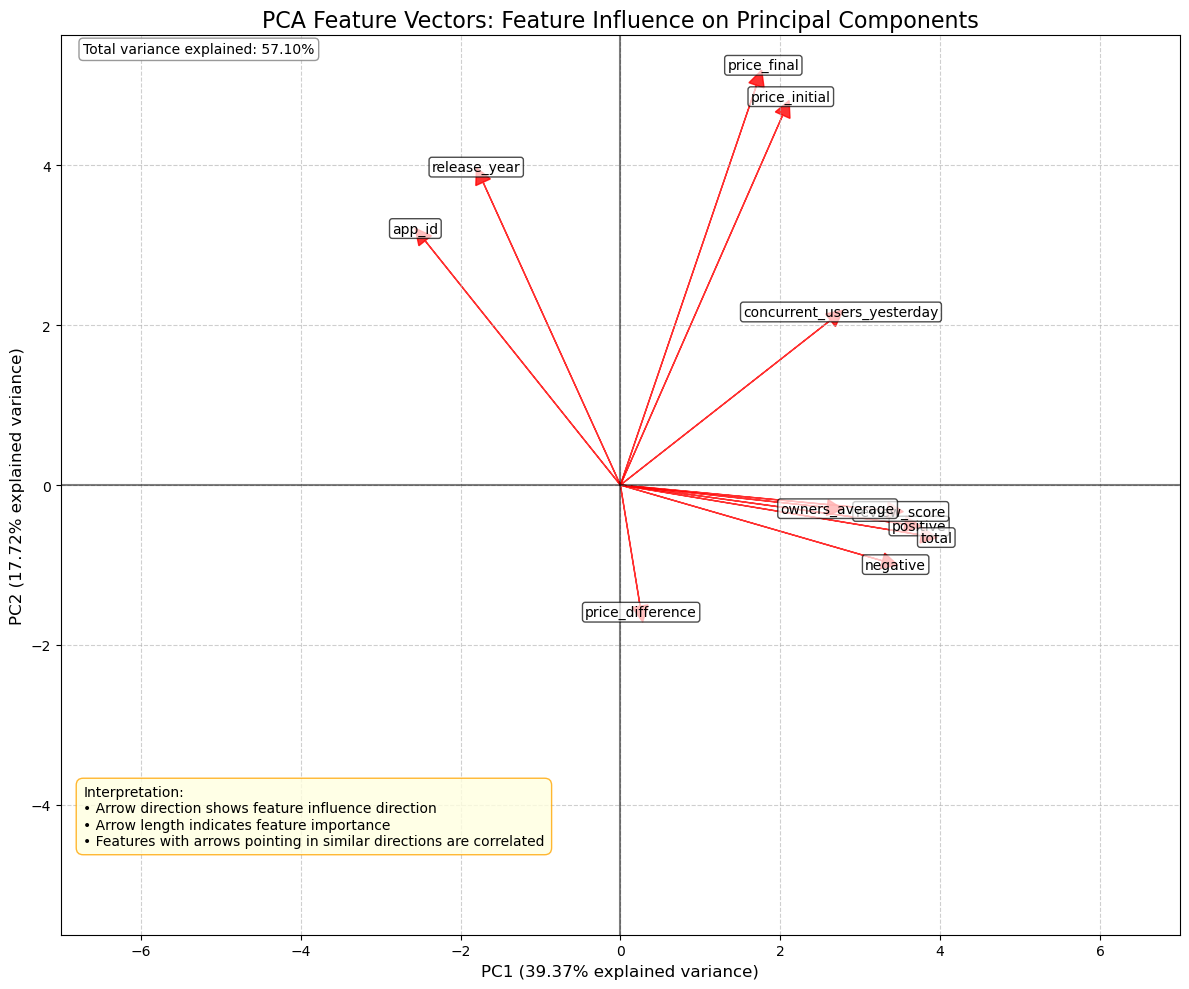

In [140]:
# Create a figure for the feature vectors only
plt.figure(figsize=(12, 10))

# Get the feature names
features = pca_data.columns.tolist()

# Get the PCA components (loadings)
loadings = pca.components_
n_components = 2  # We're only using PC1 and PC2

# Reduce the arrow scale for better visibility
arrow_scale = 5  # Reduced from 8 to 5

# Calculate the maximum arrow length for normalization
max_arrow_length = np.max(np.abs(loadings[:n_components, :]))

# Plot feature vectors
for i, feature in enumerate(features):
    # Get the loadings for this feature for the first two components
    x = loadings[0, i] * arrow_scale / max_arrow_length
    y = loadings[1, i] * arrow_scale / max_arrow_length
    
    # Draw the arrow
    plt.arrow(0, 0, x, y, color='r', alpha=0.8, head_width=0.2, head_length=0.2)
    
    # Label the arrow
    # Add a slight offset to avoid text being on top of the arrow
    text_offset = 1.05  # Reduced offset
    plt.text(x * text_offset, y * text_offset, feature, color='black', 
             ha='center', va='center', fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

# Add plot elements
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)', fontsize=12)
plt.title('PCA Feature Vectors: Feature Influence on Principal Components', fontsize=16)

# Set equal aspect ratio to ensure arrows are not distorted
plt.axis('equal')

# Set limits based on the reduced arrow scale
plt.xlim(-7, 7)
plt.ylim(-7, 7)

total_var = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]
plt.annotate(f'Total variance explained: {total_var:.2%}',
             xy=(0.02, 0.98),
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add a note explaining how to interpret the diagram
plt.annotate('Interpretation:\n'
             '• Arrow direction shows feature influence direction\n'
             '• Arrow length indicates feature importance\n'
             '• Features with arrows pointing in similar directions are correlated',
             xy=(0.02, 0.1),
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.8),
             fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\Georg\AppData\Local\Temp\ipykernel_78184\3668111741.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')  # Use a colormap with distinct colors


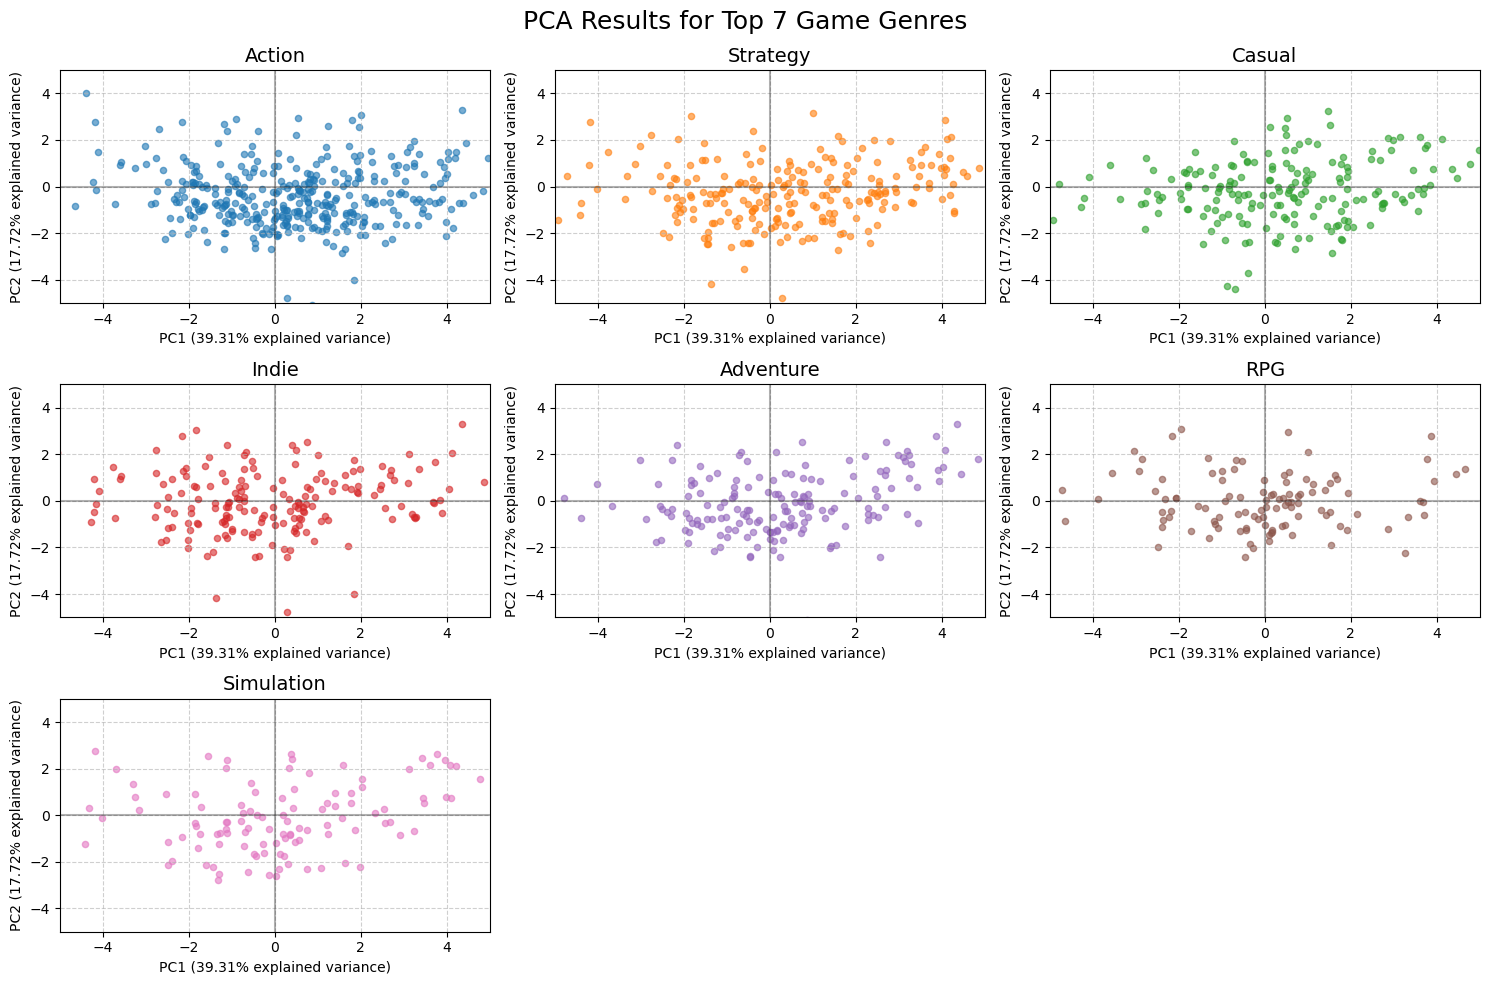

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Get top 7 genres
top_7_genres = pca_df_exploded['genre'].value_counts().nlargest(7).index.tolist()

# Create a color map for the top 7 genres
cmap = get_cmap('tab10')  # Use a colormap with distinct colors
genre_colors = {genre: cmap(i) for i, genre in enumerate(top_7_genres)}

# Set up subplots for 7 genres (arranged in a 3-column layout)
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Extra subplots will be deleted later

# Flatten axes array for easy iteration
axes = axes.flatten()

# Create scatter plot for each of the top 7 genres
for i, genre in enumerate(top_7_genres):
    ax = axes[i]
    genre_data = pca_df_exploded[pca_df_exploded['genre'] == genre]
    
    ax.scatter(
        genre_data['PC1'], 
        genre_data['PC2'],
        color=genre_colors[genre],
        alpha=0.6,
        s=20,
        label=genre
    )
    
    ax.set_title(f"{genre}", fontsize=14)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
    
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    # **Set the same scale for all plots**
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

# Remove unused subplots (since we only have 7 plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('PCA Results for Top 7 Game Genres', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


### Projecting PC1 and PC2 to each game 

### How different game genres have risen and fallen over time 

In [ ]:
# Combined dataframe of paid games and pca values 
pca_paid_games = pd.concat([filtered_paid_games, pca_df], axis=1)

pca_paid_games.head()


app_id                       name release_date  price_final  price_initial  \
0      10             Counter-Strike   2000-11-01         8.19           8.19   
1      20      Team Fortress Classic   1999-04-01         4.99           4.99   
2      30              Day of Defeat   2003-05-01         4.99           4.99   
3      40         Deathmatch Classic   2001-06-01         4.99           4.99   
4      50  Half-Life: Opposing Force   1999-11-01         4.99           4.99   

  currency  release_year  positive  review_score review_score_description  \
0      EUR          2000  235403.0             9  Overwhelmingly Positive   
1      EUR          1999    7315.0             8            Very Positive   
2      EUR          2003    6249.0             8            Very Positive   
3      EUR          2001    2542.0             8            Very Positive   
4      EUR          1999   22263.0             9  Overwhelmingly Positive   

   negative     total     genre  concurrent_users_yesterday  owners_average  \
0    6207.0  241610.0  [Action]                       11457      15000000.0   
1    1094.0    8409.0  [Action]                          52       7500000.0   
2     672.0    6921.0  [Action]                          82       7500000.0   
3     524.0    3066.0  [Action]                           6       7500000.0   
4    1111.0   23374.0  [Action]                          99       3500000.0   

                                                 tag  \
0  [1980s, 1990's, Action, Assassin, Classic, Com...   
1  [1990's, Action, Class-Based, Classic, Co-op, ...   
2  [Action, Class-Based, Classic, Co-op, Difficul...   
3  [1990's, Action, Arena Shooter, Classic, Co-op...   
4  [1990's, Action, Adventure, Aliens, Atmospheri...   

                                            category  price_difference  \
0  [Family Sharing, Multi-player, Online PvP, PvP...               0.0   
1  [Family Sharing, Multi-player, Online PvP, PvP...               0.0   
2  [Family Sharing, Multi-player, Valve Anti-Chea...               0.0   
3  [Family Sharing, Multi-player, Online PvP, PvP...               0.0   
4  [Family Sharing, Multi-player, Remote Play Tog...               0.0   

        PC1       PC2  
0  6.576903 -2.192673  
1  5.237046 -2.944681  
2  5.021830 -2.533891  
3  4.816799 -2.601511  
4  5.714318 -2.760654

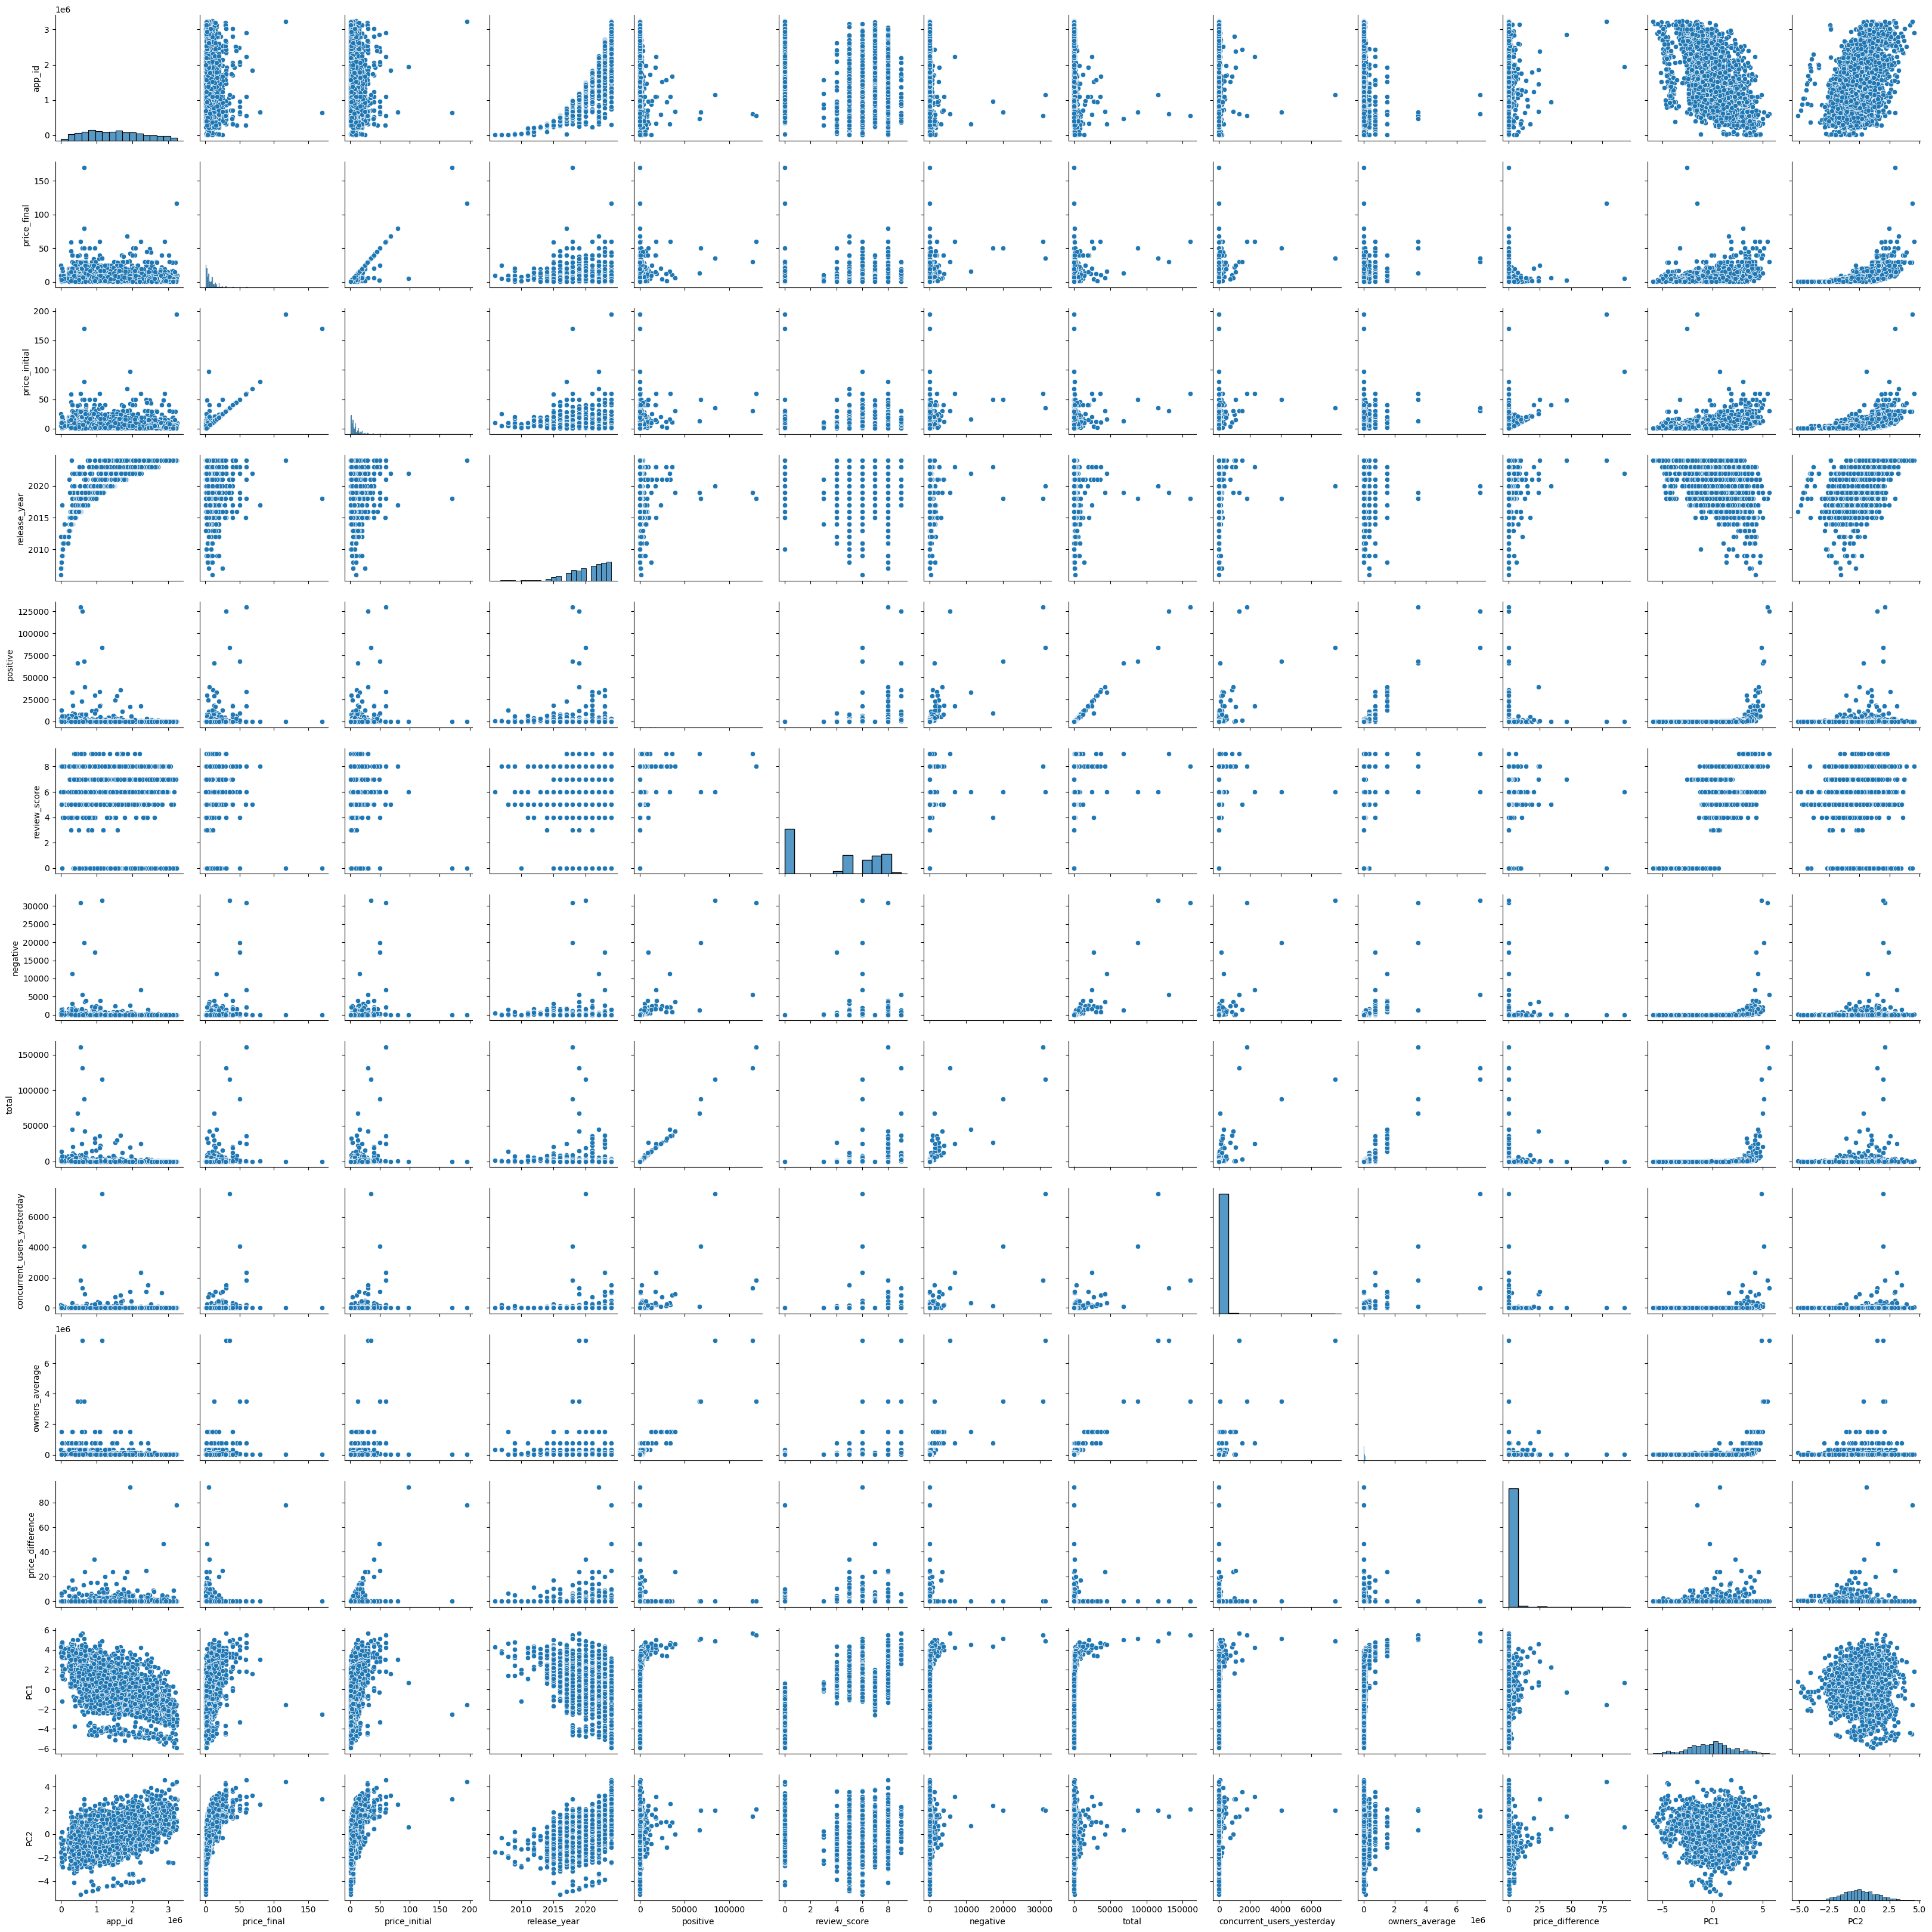

In [ ]:
tester = pca_paid_games[['app_id','price_final', 'price_initial', 'release_year', 'positive', 'review_score', 'negative', 'total', 'concurrent_users_yesterday', 'owners_average', 'price_difference', 'PC1', 'PC2']]
sampled_data = tester.sample(n=2000, random_state=42)

# Create the pairplot
pairplot = sns.pairplot(sampled_data)
plt.tight_layout()
plt.show()

<Axes: >

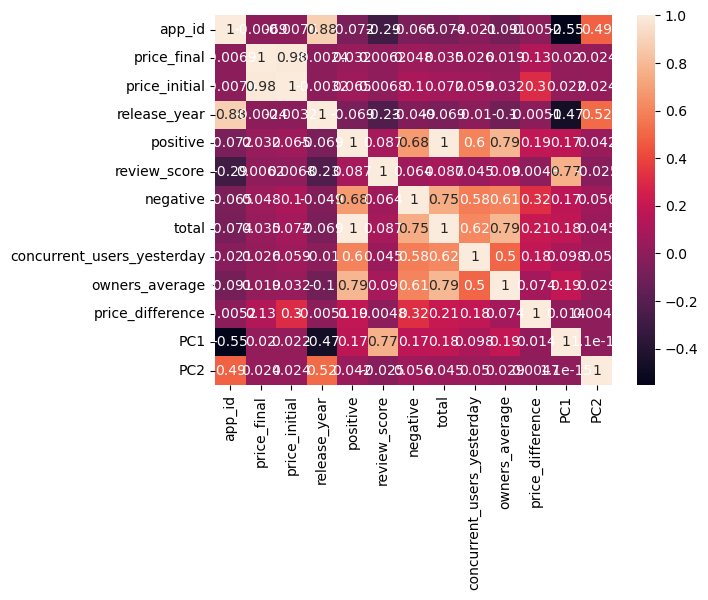

In [157]:
heat_map = pca_paid_games[['app_id','price_final', 'price_initial', 'release_year', 'positive', 'review_score', 'negative', 'total', 'concurrent_users_yesterday', 'owners_average', 'price_difference', 'PC1', 'PC2']]
sns.heatmap(heat_map.corr(), annot=True)

In [223]:
# Sort by PC1 value in descending order (highest PC1 first)
sorted_games = pca_paid_games.sort_values(by='PC1', ascending=False).reset_index()



In [238]:

# Initialize min max scaler to be in the range of 0,1
scaler = MinMaxScaler(feature_range=(0, 1))
exploded_sorted_games = sorted_games.explode('genre')
# Scale just the PC1 and PC2 columns, applying directly to exploded_sorted_games
exploded_sorted_games[['PC1', 'PC2']] = scaler.fit_transform(exploded_sorted_games[['PC1', 'PC2']])

action_games = exploded_sorted_games[exploded_sorted_games['genre'] == 'Action']
Adventure_games = exploded_sorted_games[exploded_sorted_games['genre'] == 'Adventure']
Indie_games = exploded_sorted_games[exploded_sorted_games['genre'] == 'Indie']
Massively_Multiplayer_games = exploded_sorted_games[exploded_sorted_games['genre'] == 'Massively Multiplayer']
RPG_games = exploded_sorted_games[exploded_sorted_games['genre'] == 'RPG']
Simulation_games = exploded_sorted_games[exploded_sorted_games['genre'] == 'Simulation']
Strategy_games = exploded_sorted_games[exploded_sorted_games['genre'] == 'Strategy']





### Line chart with average popularity by genre over time
- Due to the increased number of games being released, the standard of games has decreased 

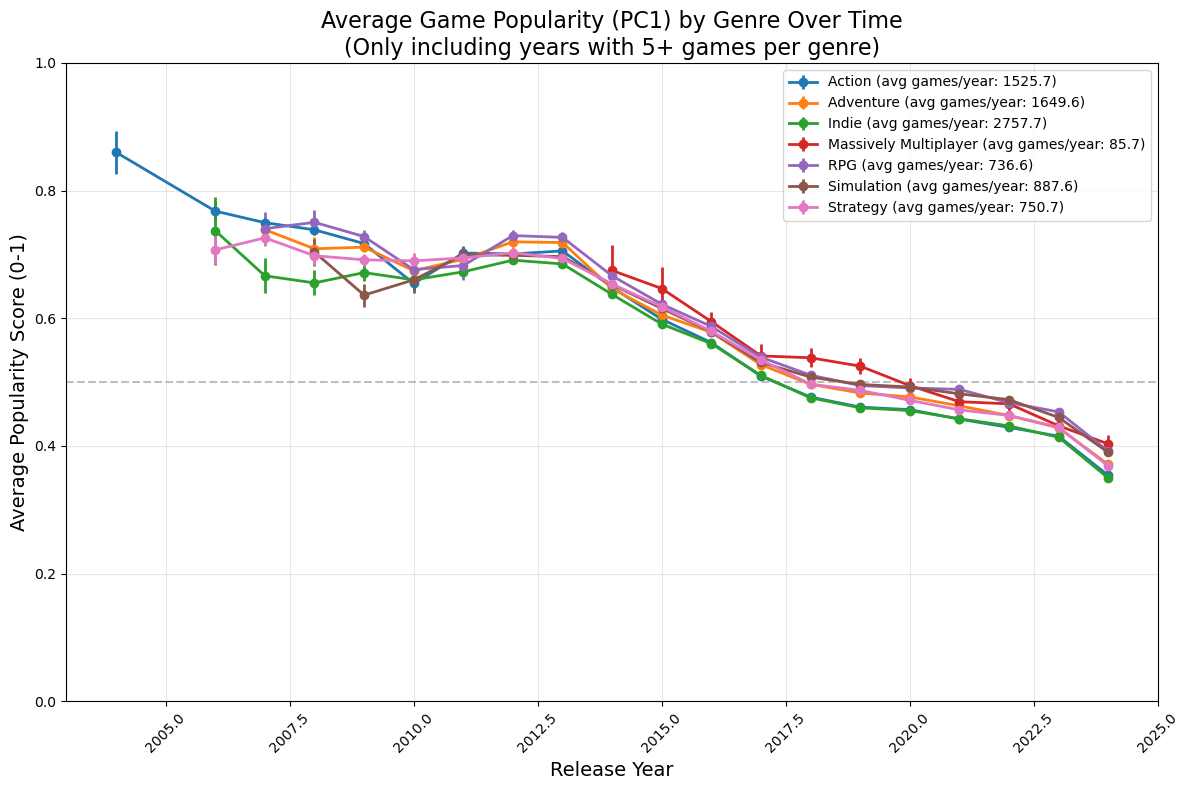

In [249]:
def plot_genre_trends_line_improved():
    plt.figure(figsize=(12, 8))
    
    # Store data for all genres and years to calculate relative rankings
    all_years_data = []
    
    # First pass: collect all data points
    for genre, data in [
        ('Action', action_games),
        ('Adventure', Adventure_games),
        ('Indie', Indie_games),
        ('Massively Multiplayer', Massively_Multiplayer_games),
        ('RPG', RPG_games),
        ('Simulation', Simulation_games),
        ('Strategy', Strategy_games)
    ]:
        yearly_data = data.groupby('release_year').agg({
            'PC1': ['mean', 'std', 'count']
        }).reset_index()
        yearly_data.columns = ['release_year', 'mean', 'std', 'count']
        yearly_data['genre'] = genre
        all_years_data.append(yearly_data)
    
    # Combine all data
    combined_data = pd.concat(all_years_data)
    
    # Only include years with at least 5 games per genre
    filtered_data = combined_data[combined_data['count'] >= 5]
    
    # For each year, calculate percentile rank of each genre
    yearly_ranks = {}
    for year, year_data in filtered_data.groupby('release_year'):
        if len(year_data) >= 3:  # At least 3 genres with sufficient data
            yearly_ranks[year] = {}
            for _, row in year_data.iterrows():
                yearly_ranks[year][row['genre']] = row['mean']
    
    # Plot each genre
    for genre, data in [
        ('Action', action_games),
        ('Adventure', Adventure_games),
        ('Indie', Indie_games),
        ('Massively Multiplayer', Massively_Multiplayer_games),
        ('RPG', RPG_games),
        ('Simulation', Simulation_games),
        ('Strategy', Strategy_games)
    ]:
        # Filter to years with sufficient data
        yearly_avg = filtered_data[filtered_data['genre'] == genre]
        
        # Plot with error bars
        plt.errorbar(
            yearly_avg['release_year'], 
            yearly_avg['mean'], 
            yerr=yearly_avg['std'] / np.sqrt(yearly_avg['count']),  # Standard error
            marker='o', 
            linewidth=2, 
            label=f"{genre} (avg games/year: {yearly_avg['count'].mean():.1f})"
        )
    
    plt.title('Average Game Popularity (PC1) by Genre Over Time\n(Only including years with 5+ games per genre)', fontsize=16)
    plt.xlabel('Release Year', fontsize=14)
    plt.ylabel('Average Popularity Score (0-1)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)
    plt.ylim(0, 1)
    
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt

# Just call the function
plot_genre_trends_line_improved()

# If you want to display the plot
plt.show()



<module 'matplotlib.pyplot' from 'c:\\Users\\Georg\\anaconda3\\envs\\steam_analysis\\Lib\\site-packages\\matplotlib\\pyplot.py'>

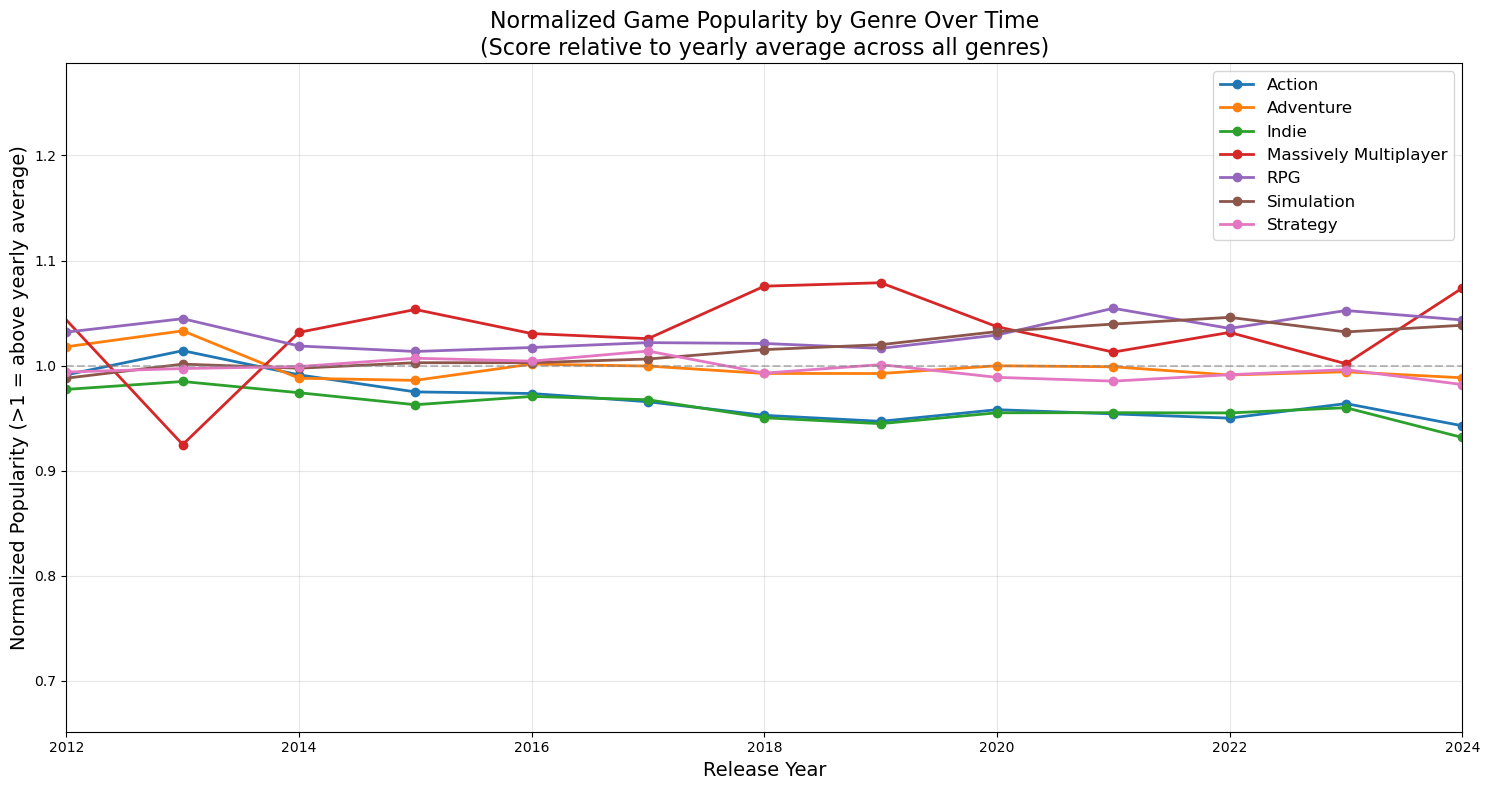

In [257]:
def plot_normalized_genre_trends():
    plt.figure(figsize=(15, 8))
    
    # Prepare a dataframe to collect all genre data
    all_genre_data = pd.DataFrame()
    
    # Gather data for all genres
    for genre, data in [
        ('Action', action_games),
        ('Adventure', Adventure_games),
        ('Indie', Indie_games),
        ('Massively Multiplayer', Massively_Multiplayer_games),
        ('RPG', RPG_games),
        ('Simulation', Simulation_games),
        ('Strategy', Strategy_games)
    ]:
        # Group by year and calculate mean PC1
        yearly_avg = data.groupby('release_year')['PC1'].mean().reset_index()
        yearly_avg['genre'] = genre
        all_genre_data = pd.concat([all_genre_data, yearly_avg])
    
    # Calculate the mean score across all genres for each year
    yearly_means = all_genre_data.groupby('release_year')['PC1'].mean().reset_index()
    yearly_means.rename(columns={'PC1': 'year_mean'}, inplace=True)
    
    # Merge back to get year means alongside genre scores
    all_genre_data = pd.merge(all_genre_data, yearly_means, on='release_year')
    
    # Calculate normalized scores (genre score relative to year average)
    all_genre_data['normalized_score'] = all_genre_data['PC1'] / all_genre_data['year_mean']
    
    # Plot each genre separately
    for genre in all_genre_data['genre'].unique():
        genre_data = all_genre_data[all_genre_data['genre'] == genre]
        plt.plot(genre_data['release_year'], genre_data['normalized_score'], 
                 marker='o', linewidth=2, label=genre)
    
    # Set horizontal reference line at 1.0 (equal to year average)
    plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    
    # Customize plot
    plt.title('Normalized Game Popularity by Genre Over Time\n(Score relative to yearly average across all genres)', fontsize=16)
    plt.xlabel('Release Year', fontsize=14)
    plt.ylabel('Normalized Popularity (>1 = above yearly average)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xlim(2012,2024)
    plt.legend(loc='best', fontsize=12)
    
    # Create specific years to mark on the axis for better spacing
    
    plt.tight_layout()
    return plt


plot_normalized_genre_trends()

### Box plots by year and genre



C:\Users\Georg\AppData\Local\Temp\ipykernel_78184\3945257073.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_by_genre, patch_artist=True, labels=genres)


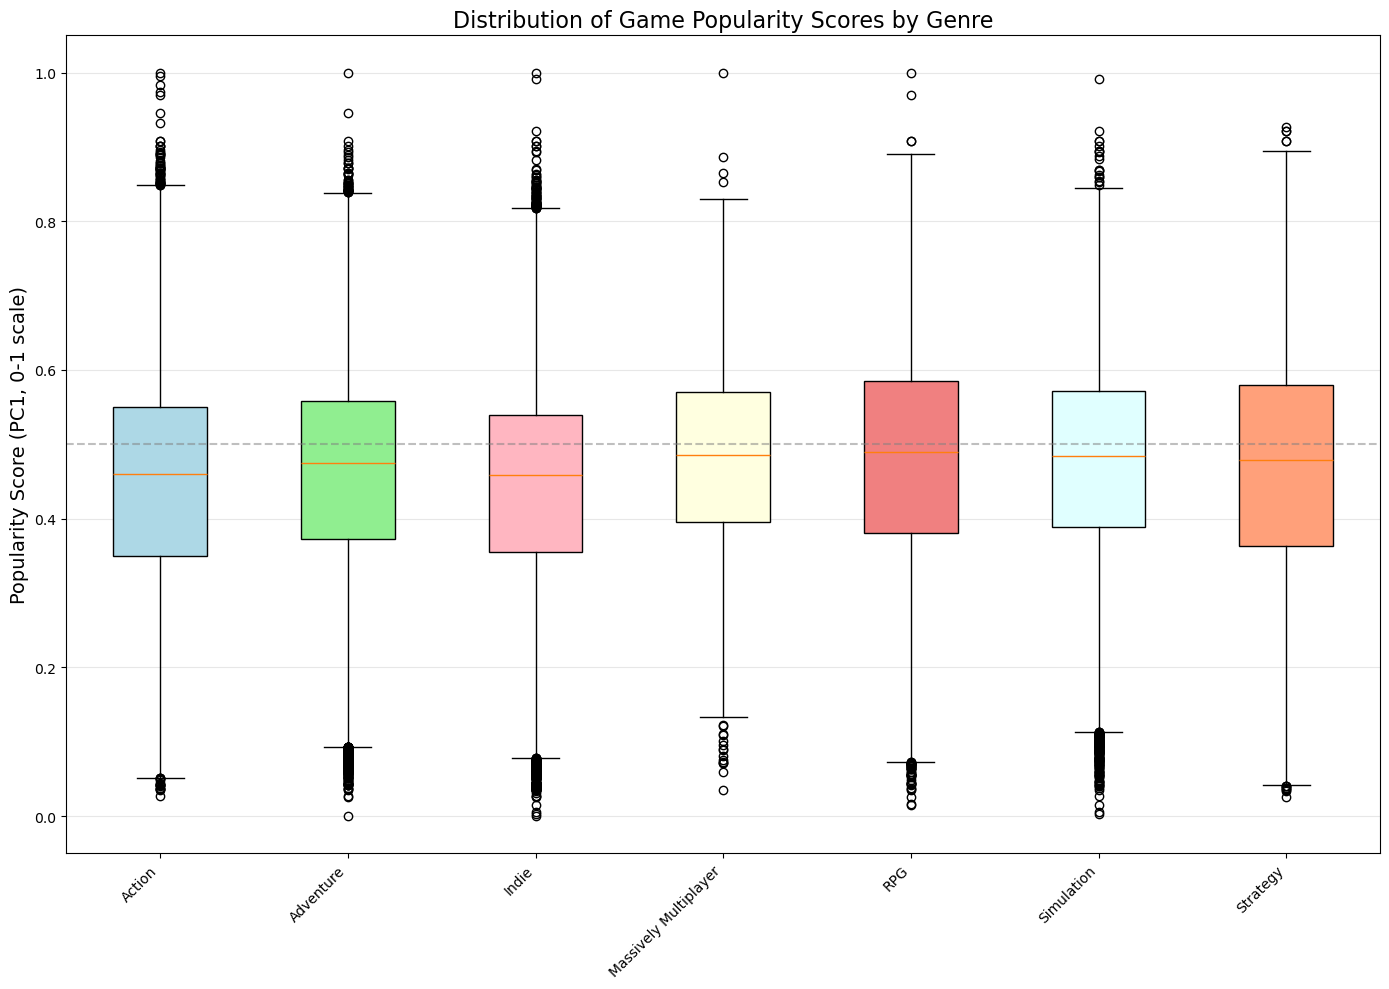

In [245]:
def plot_genre_boxplots():
    plt.figure(figsize=(14, 10))
    
    # Create a list to store data for boxplot
    genres = ['Action', 'Adventure', 'Indie', 'Massively Multiplayer', 'RPG', 'Simulation', 'Strategy']
    data_by_genre = []
    
    for genre, data in [
        ('Action', action_games),
        ('Adventure', Adventure_games),
        ('Indie', Indie_games),
        ('Massively Multiplayer', Massively_Multiplayer_games),
        ('RPG', RPG_games),
        ('Simulation', Simulation_games),
        ('Strategy', Strategy_games)
    ]:
        data_by_genre.append(data['PC1'].values)
    
    # Create the boxplot
    box = plt.boxplot(data_by_genre, patch_artist=True, labels=genres)
    
    # Customize boxplot colors
    colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow', 'lightcoral', 'lightcyan', 'lightsalmon']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.title('Distribution of Game Popularity Scores by Genre', fontsize=16)
    plt.ylabel('Popularity Score (PC1, 0-1 scale)', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    
    # Add a horizontal line at 0.5 for reference
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    return plt

# Call the function
plot_genre_boxplots()

# Display the plot
plt.show()

### Heat map visualization

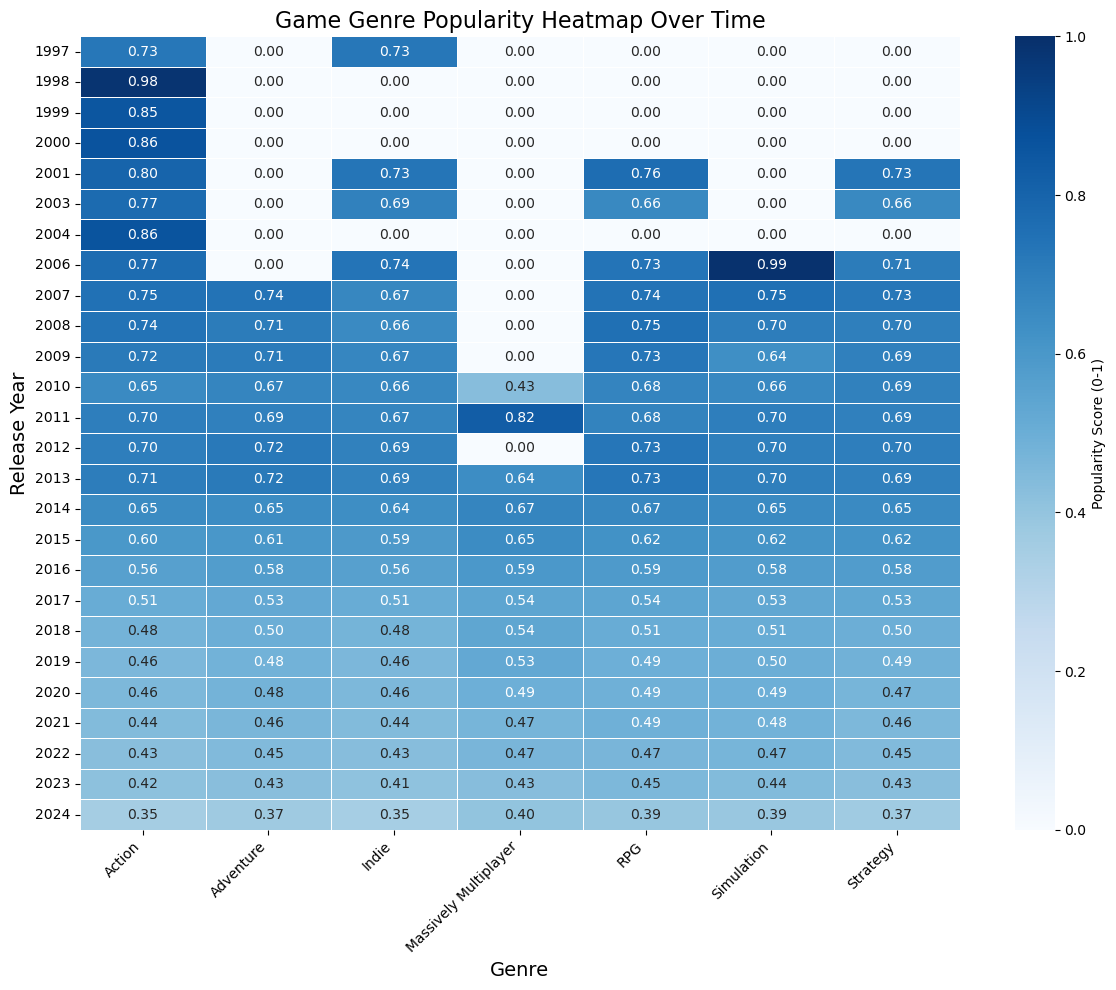

In [244]:
def plot_genre_heatmap():
    # Create a pivot table with years as rows, genres as columns, and average PC1 as values
    pivot_data = pd.DataFrame()
    
    # Collect data for each genre
    for genre, data in [
        ('Action', action_games),
        ('Adventure', Adventure_games),
        ('Indie', Indie_games),
        ('Massively Multiplayer', Massively_Multiplayer_games),
        ('RPG', RPG_games),
        ('Simulation', Simulation_games),
        ('Strategy', Strategy_games)
    ]:
        # Group by year and get average popularity
        yearly_avg = data.groupby('release_year')['PC1'].mean()
        if pivot_data.empty:
            pivot_data = pd.DataFrame(index=yearly_avg.index)
        pivot_data[genre] = yearly_avg
    
    # Fill missing values (years where a genre had no games)
    pivot_data = pivot_data.fillna(0)
    
    # Sort by year
    pivot_data = pivot_data.sort_index()
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    
    # Use a sequential colormap that goes from light to dark
    sns.heatmap(pivot_data, annot=True, cmap='Blues', fmt='.2f', 
                linewidths=.5, vmin=0, vmax=1, cbar_kws={'label': 'Popularity Score (0-1)'})
    
    plt.title('Game Genre Popularity Heatmap Over Time', fontsize=16)
    plt.ylabel('Release Year', fontsize=14)
    plt.xlabel('Genre', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    return plt


# Call the function
plot_genre_heatmap()

# Display the plot
plt.show()

## Temporal Trends 

### Genre Evolution Over Time by number of games in genre vs release year - Paid Games

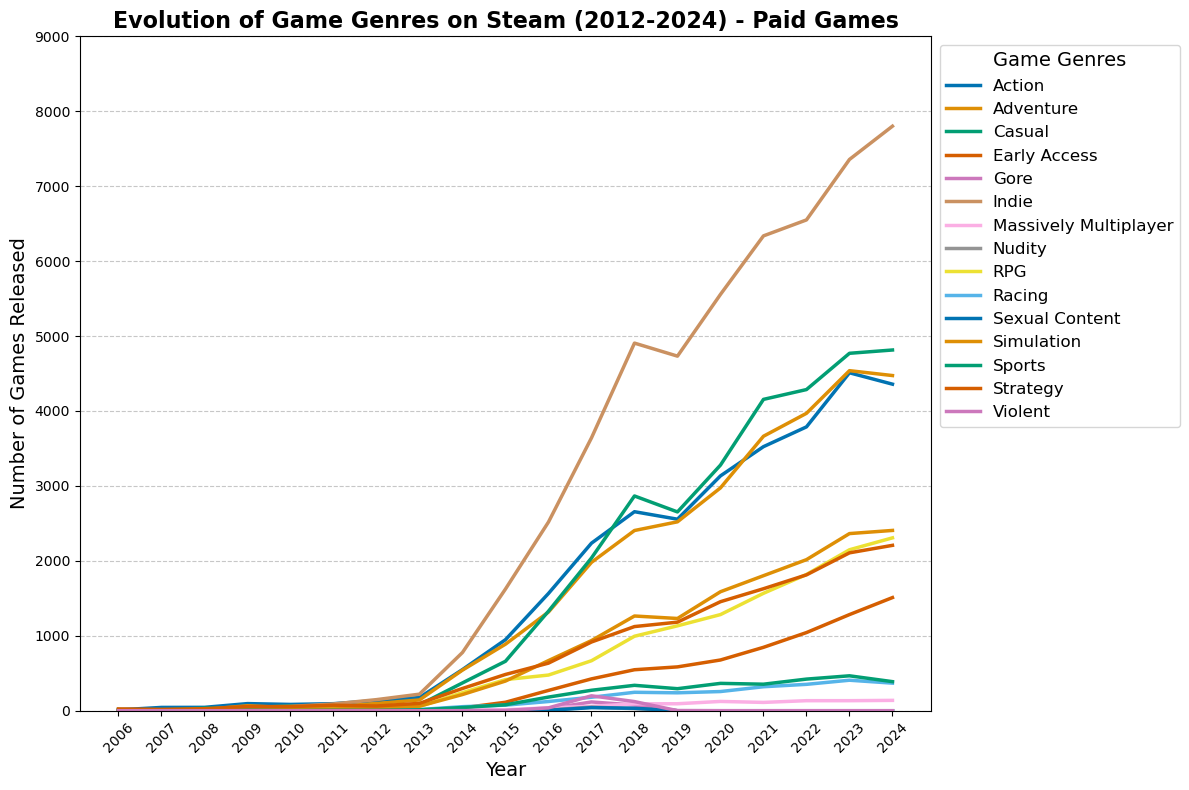

In [ ]:
# Use the existing filtered_paid_games dataset instead of reprocessing
# We need to explode the genre list since it was aggregated in your preprocessing
genre_data = filtered_paid_games.explode('genre')       # Explode expands the list 

# Count games by release year and genre
genre_counts = genre_data.groupby(['release_year', 'genre']).size().reset_index(name='count')

# Create pivot table
genre_pivot = genre_counts.pivot(index='release_year', columns='genre', values='count')
genre_pivot = genre_pivot.fillna(0)
genre_pivot = genre_pivot.sort_index()
genre_pivot = genre_pivot.loc[2006:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam (2012-2024) - Paid Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Games Released", fontsize=14)
plt.ylim((0,9000))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
           loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()


- There had been a blast in indie games released 

### Genre Evolution Over Time by number of games in genre vs release year - Free Games

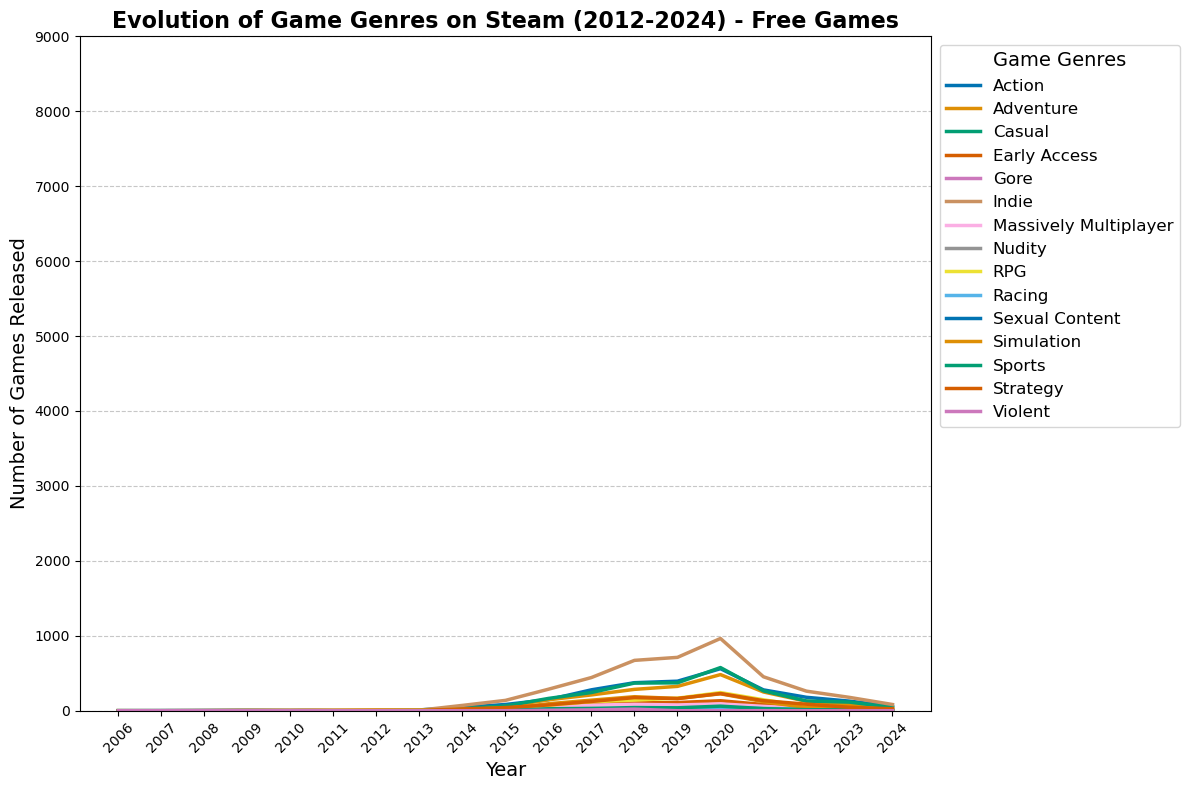

In [ ]:
# Use the existing filtered_free_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
genre_data = filtered_free_games.explode('genre')

# Count games by release year and genre
genre_counts = genre_data.groupby(['release_year', 'genre']).size().reset_index(name='count')

# Create pivot table
genre_pivot = genre_counts.pivot(index='release_year', columns='genre', values='count')
genre_pivot = genre_pivot.fillna(0)
genre_pivot = genre_pivot.sort_index()
genre_pivot = genre_pivot.loc[2006:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam (2012-2024) - Free Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Games Released", fontsize=14)
plt.ylim((0,9000))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
           loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()

- Free games peaked in 2020 by release 

### Genre Evolution Over Time by positive reviews in genre vs release year - Paid Games 

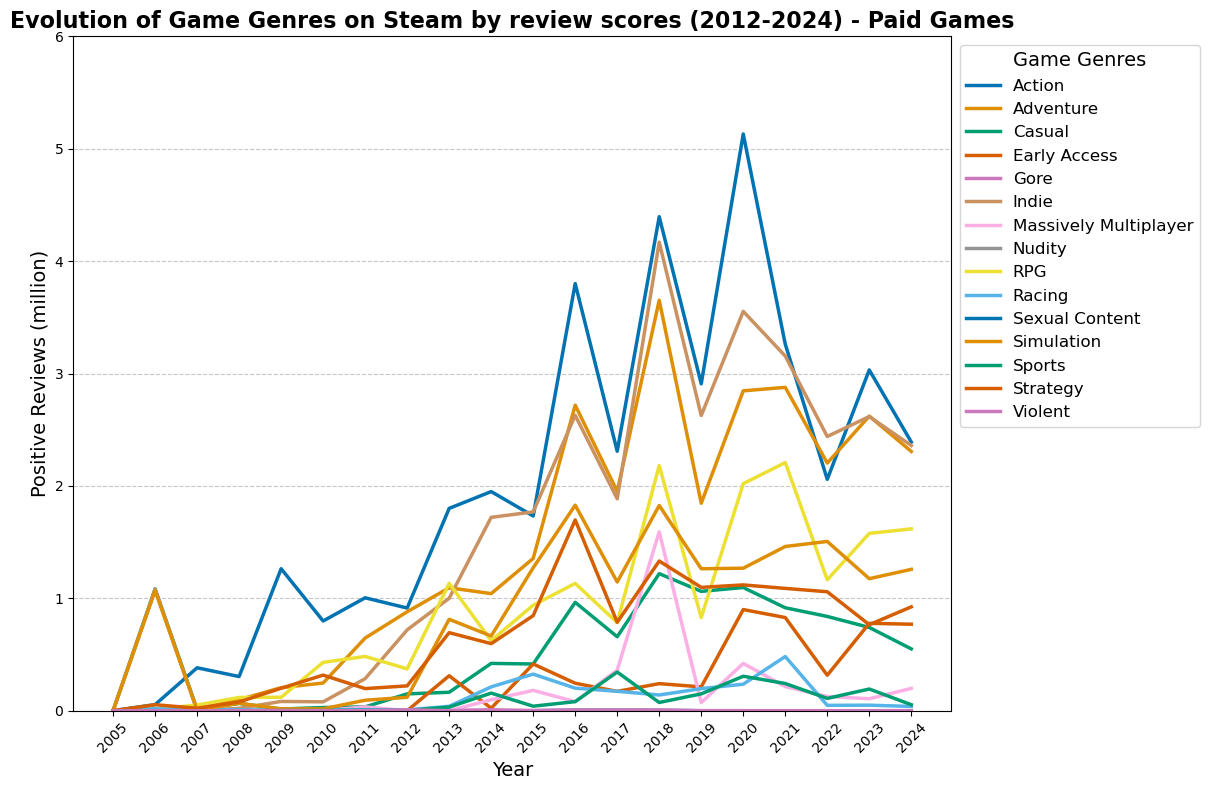

In [ ]:
# Use the existing filtered_paid_games dataset 
# We need to explode the genre list since it was aggregated in your preprocessing
reviews_data = filtered_paid_games.explode('genre')

# Group by release_year and genre, and sum the positive reviews
genre_reviews = reviews_data.groupby(['release_year', 'genre'])['positive'].sum().reset_index()

# Convert the number of positive reviews to millions 
genre_reviews['positive'] = genre_reviews['positive']/1000000

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_reviews.pivot(index='release_year', columns='genre', values='positive')

# Fill any NaN values with 0 (years where a genre had no positive reviews)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

genre_pivot = genre_pivot.loc[2005:]


# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by review scores (2012-2024) - Paid Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Positive Reviews (million)", fontsize=14)
plt.ylim((0,6))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()


### Genre Evolution Over Time by positive reviews in genre vs release year - Free Games 

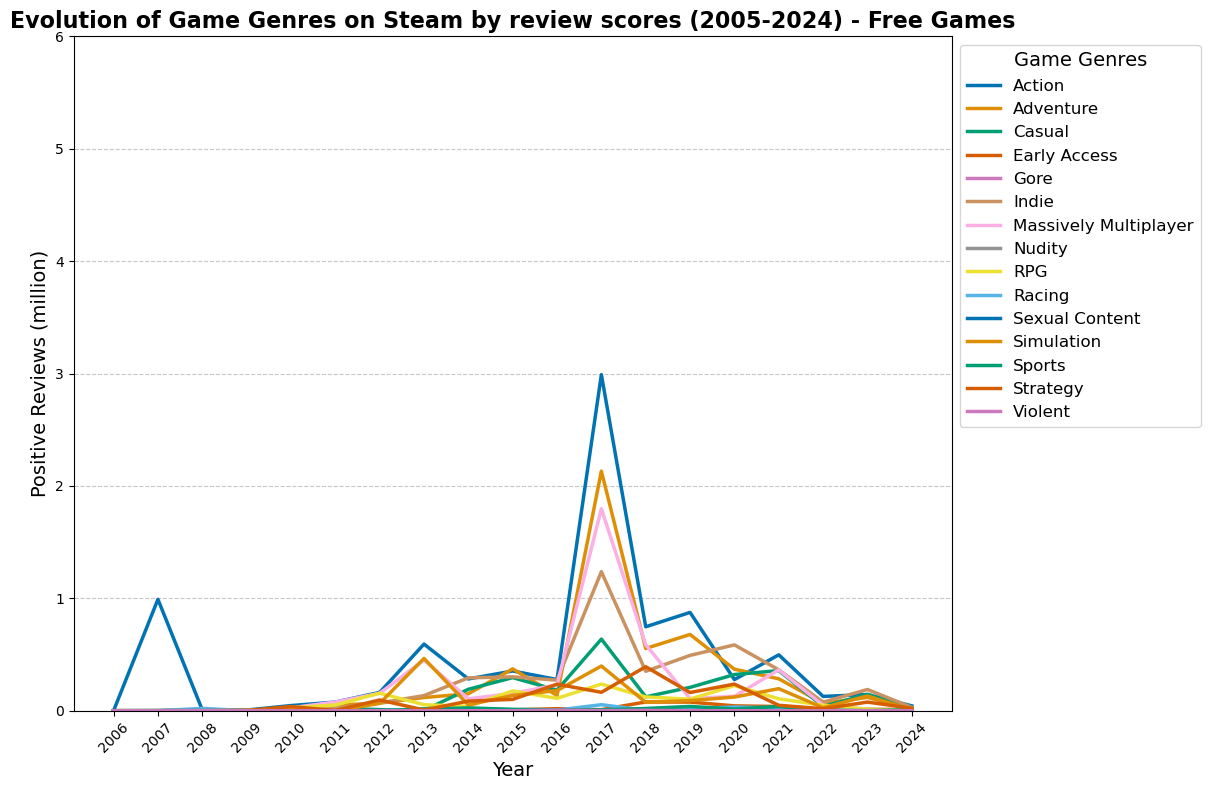

In [ ]:
# Use the existing filtered_free_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
reviews_data = filtered_free_games.explode('genre')

# Group by release_year and genre, and sum the positive reviews
genre_reviews = reviews_data.groupby(['release_year', 'genre'])['positive'].sum().reset_index()

# Convert the number of positive reviews to millions 
genre_reviews['positive'] = genre_reviews['positive']/1000000

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_reviews.pivot(index='release_year', columns='genre', values='positive')

# Fill any NaN values with 0 (years where a genre had no positive reviews)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

# Filter to years >= 2005 (changed from 2012 as requested)
genre_pivot = genre_pivot.loc[2005:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by review scores (2005-2024) - Free Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Positive Reviews (million)", fontsize=14)
plt.ylim((0,6))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()

### Genre Evolution Over Time by player count in genre vs release year - Paid Games

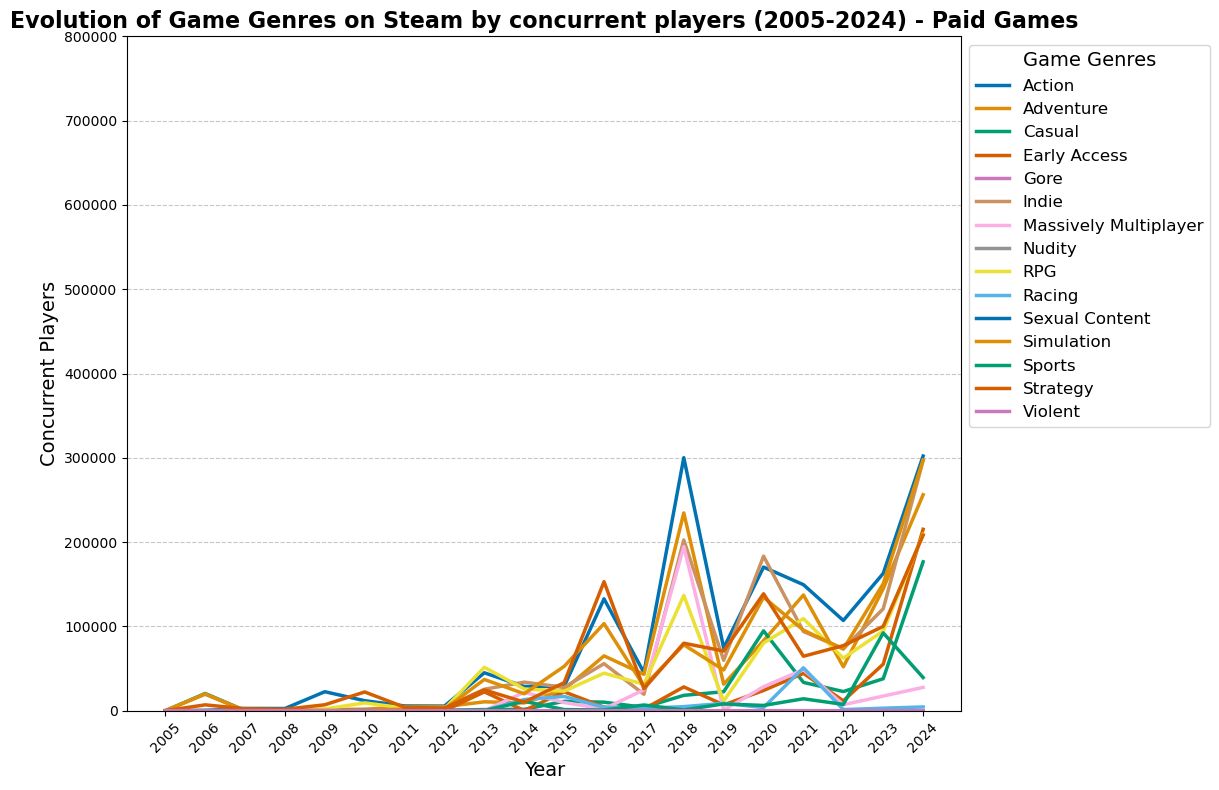

In [ ]:
# Use the existing filtered_paid_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
players_data = filtered_paid_games.explode('genre')

# Group by release_year and genre, and sum the concurrent users
genre_players = players_data.groupby(['release_year', 'genre'])['concurrent_users_yesterday'].sum().reset_index()

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_players.pivot(index='release_year', columns='genre', values='concurrent_users_yesterday')

# Fill any NaN values with 0 (years where a genre had no concurrent players)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

# Filter to years >= 2005 (changed from 2012)
genre_pivot = genre_pivot.loc[2005:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by concurrent players (2005-2024) - Paid Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Concurrent Players", fontsize=14)
plt.ylim((0,800000))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()


### Genre Evolution Over Time by player count in genre vs release year - Free Games

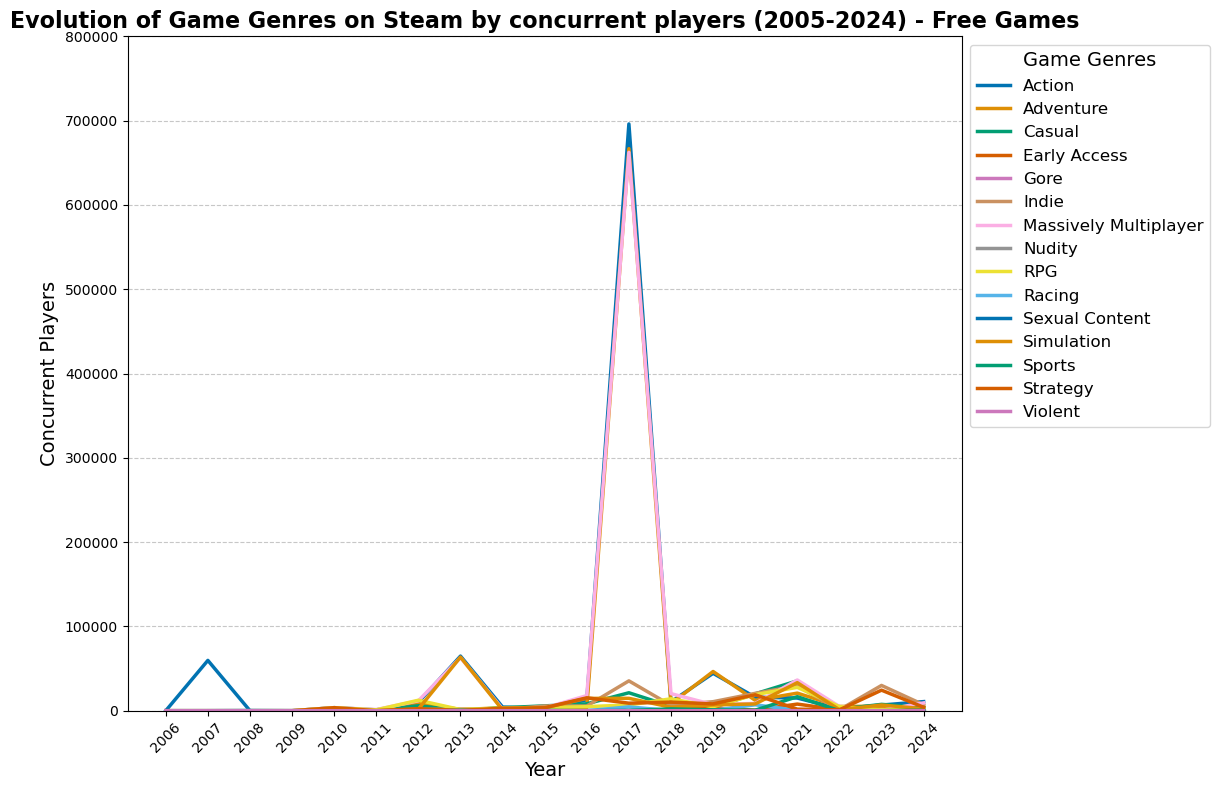

In [ ]:
# Use the existing filtered_free_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
players_data = filtered_free_games.explode('genre')

# Group by release_year and genre, and sum the concurrent users
genre_players = players_data.groupby(['release_year', 'genre'])['concurrent_users_yesterday'].sum().reset_index()

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_players.pivot(index='release_year', columns='genre', values='concurrent_users_yesterday')

# Fill any NaN values with 0 (years where a genre had no concurrent players)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

# Filter to years >= 2005 (changed from 2012)
genre_pivot = genre_pivot.loc[2005:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by concurrent players (2005-2024) - Free Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Concurrent Players", fontsize=14)
plt.ylim((0,800000))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()

### Sales vs Year categorised into genres - Paid Games

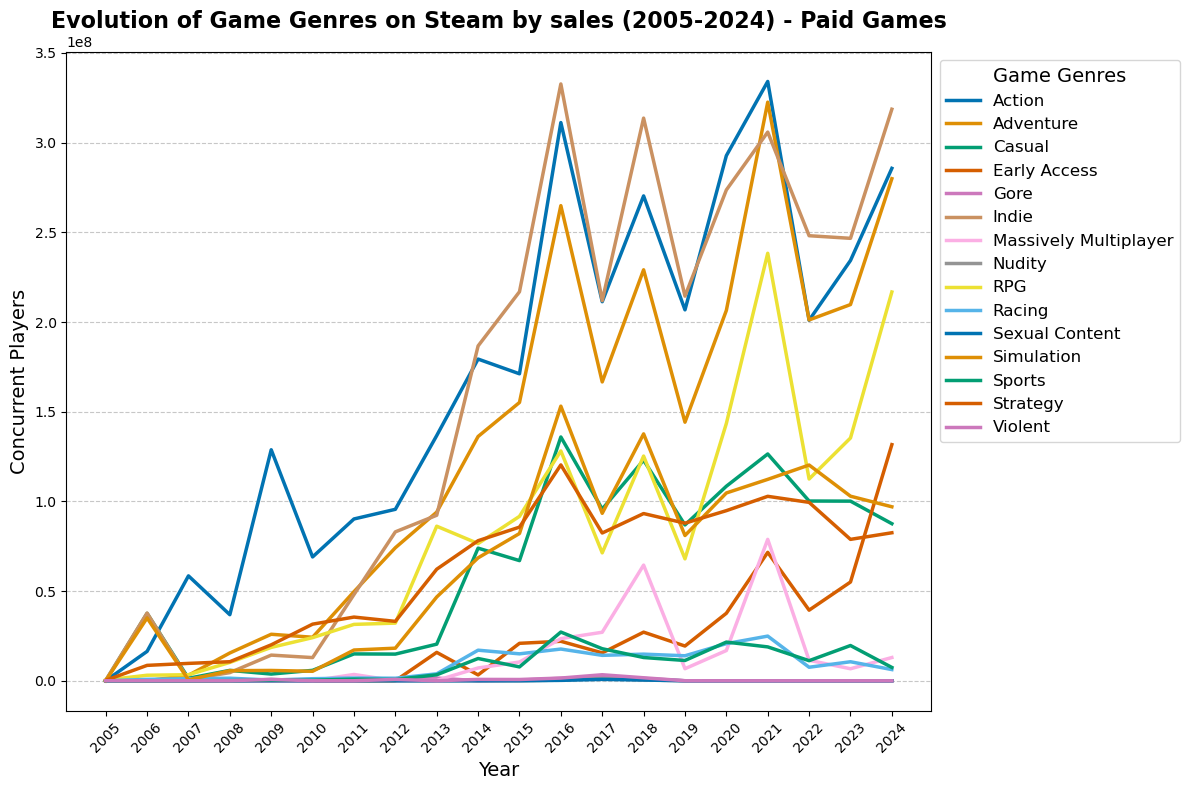

In [ ]:
# Use the existing filtered_paid_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
players_data = filtered_paid_games.explode('genre')

# Group by release_year and genre, and sum the concurrent users
genre_players = players_data.groupby(['release_year', 'genre'])['owners_average'].sum().reset_index()

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_players.pivot(index='release_year', columns='genre', values='owners_average')

# Fill any NaN values with 0 (years where a genre had no concurrent players)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

# Filter to years >= 2005 (changed from 2012)
genre_pivot = genre_pivot.loc[2005:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by sales (2005-2024) - Paid Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Concurrent Players", fontsize=14)

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()

### Sales vs Year categorised into genres - Free Games

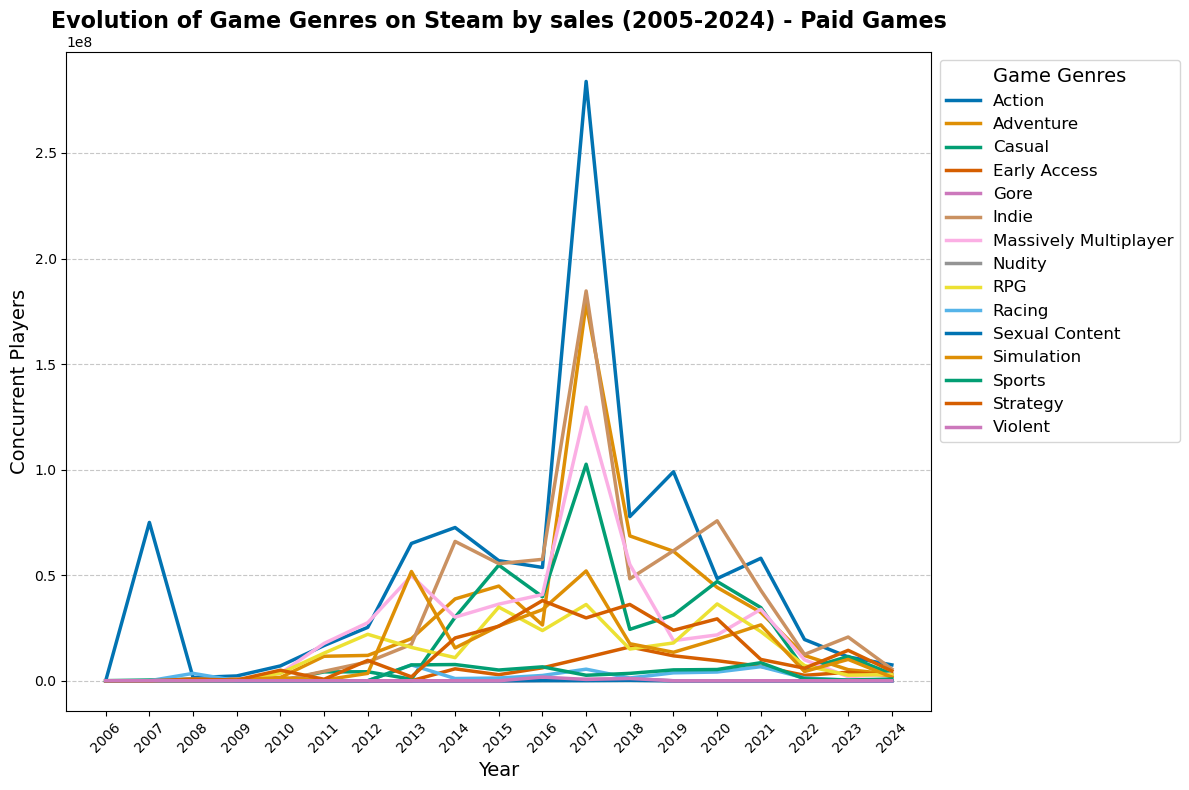

In [ ]:
# Use the existing filtered_paid_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
players_data = filtered_free_games.explode('genre')

# Group by release_year and genre, and sum the concurrent users
genre_players = players_data.groupby(['release_year', 'genre'])['owners_average'].sum().reset_index()

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_players.pivot(index='release_year', columns='genre', values='owners_average')

# Fill any NaN values with 0 (years where a genre had no concurrent players)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

# Filter to years >= 2005 (changed from 2012)
genre_pivot = genre_pivot.loc[2005:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by sales (2005-2024) - Paid Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Concurrent Players", fontsize=14)

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()

### Exploring top paid games in 2018

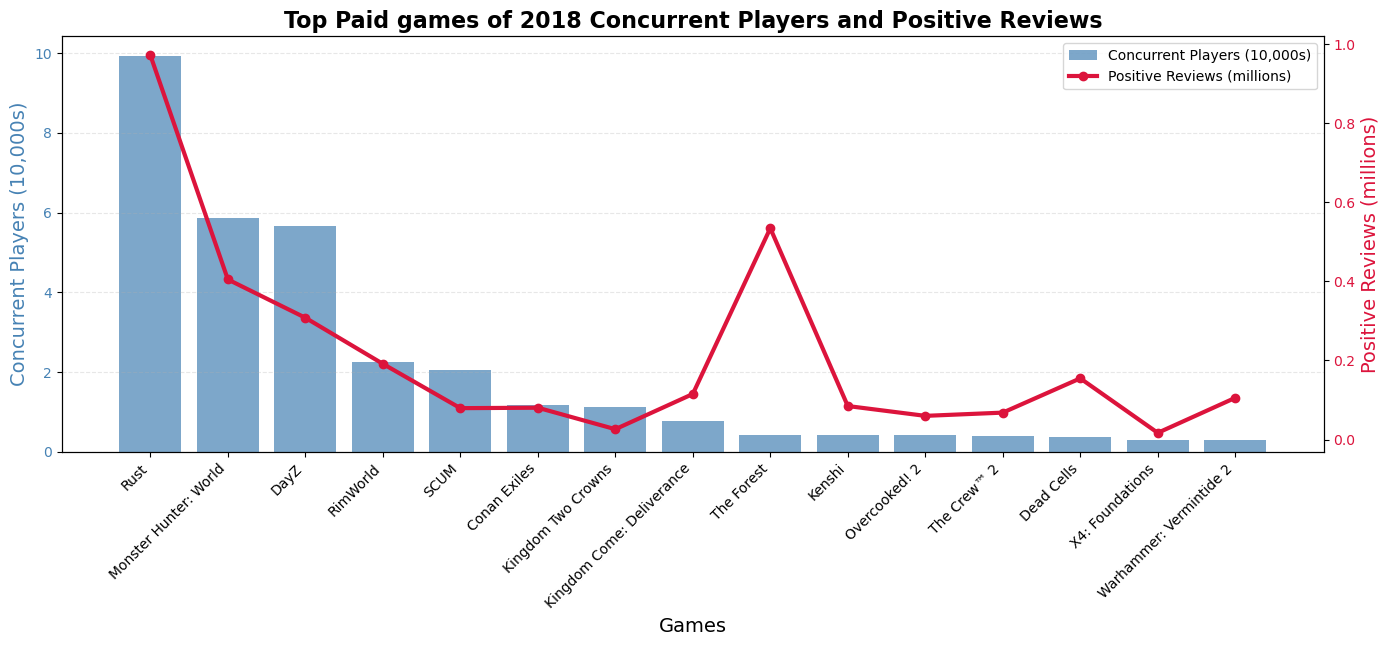

In [ ]:
# Explode the genre column from filtered_paid_games
paid_games_2018 = filtered_paid_games.explode('genre')

# Filter for games released in 2018
paid_games_2018 = paid_games_2018[paid_games_2018['release_year'] == 2018]

# Filter for only the top genres
paid_games_2018 = paid_games_2018[(paid_games_2018['genre'] == 'Indie') |
                                  (paid_games_2018['genre'] == 'Action') |
                                  (paid_games_2018['genre'] == 'Adventure') |
                                  (paid_games_2018['genre'] == 'Massively Multiplayer') |
                                  (paid_games_2018['genre'] == 'RPG') |
                                  (paid_games_2018['genre'] == 'Simulation')]

# Re-aggregate the genres into lists by game
paid_games_2018 = paid_games_2018.groupby(['app_id', 'name','release_year', 'positive', 
                                           'concurrent_users_yesterday'])['genre'].agg(list).reset_index()

# Display the first few rows
top_paid_games_2018 = paid_games_2018.sort_values('concurrent_users_yesterday', ascending=False)
top_paid_games_2018 = top_paid_games_2018[top_paid_games_2018['concurrent_users_yesterday'] >= 2844]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Sort by concurrent players descending
top_games = top_paid_games_2018.copy()

# Convert to appropriate scales
top_games['concurrent_users_scaled'] = top_games['concurrent_users_yesterday'] / 10000
top_games['positive_millions'] = top_games['positive'] / 1000000

# Plot concurrent players as bars on the primary axis (in 10,000s)
bars = ax1.bar(range(len(top_games)), top_games['concurrent_users_scaled'], color='steelblue', alpha=0.7, label='Concurrent Players')
ax1.set_xlabel('Games', fontsize=14)
ax1.set_ylabel('Concurrent Players (10,000s)', color='steelblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Create the secondary axis for positive reviews (in millions)
ax2 = ax1.twinx()
line = ax2.plot(range(len(top_games)), top_games['positive_millions'], color='crimson', marker='o', linewidth=3, label='Positive Reviews')[0]
ax2.set_ylabel('Positive Reviews (millions)', color='crimson', fontsize=14)
ax2.tick_params(axis='y', labelcolor='crimson')

# Set the game names as x-tick labels - force 45 degree rotation
ax1.set_xticks(range(len(top_games)))
ax1.set_xticklabels(top_games['name'], rotation=45, ha='right')

# Add title and grid
plt.title('Top Paid games of 2018 Concurrent Players and Positive Reviews', fontsize=16, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend without custom lines
ax1.legend([bars, line], ['Concurrent Players (10,000s)', 'Positive Reviews (millions)'], loc='upper right')

# Add bottom padding for the rotated labels
plt.subplots_adjust(bottom=0.3)

# Apply tight layout but with specific bottom padding
fig.tight_layout(rect=[0, 0.15, 1, 0.97])

plt.show()


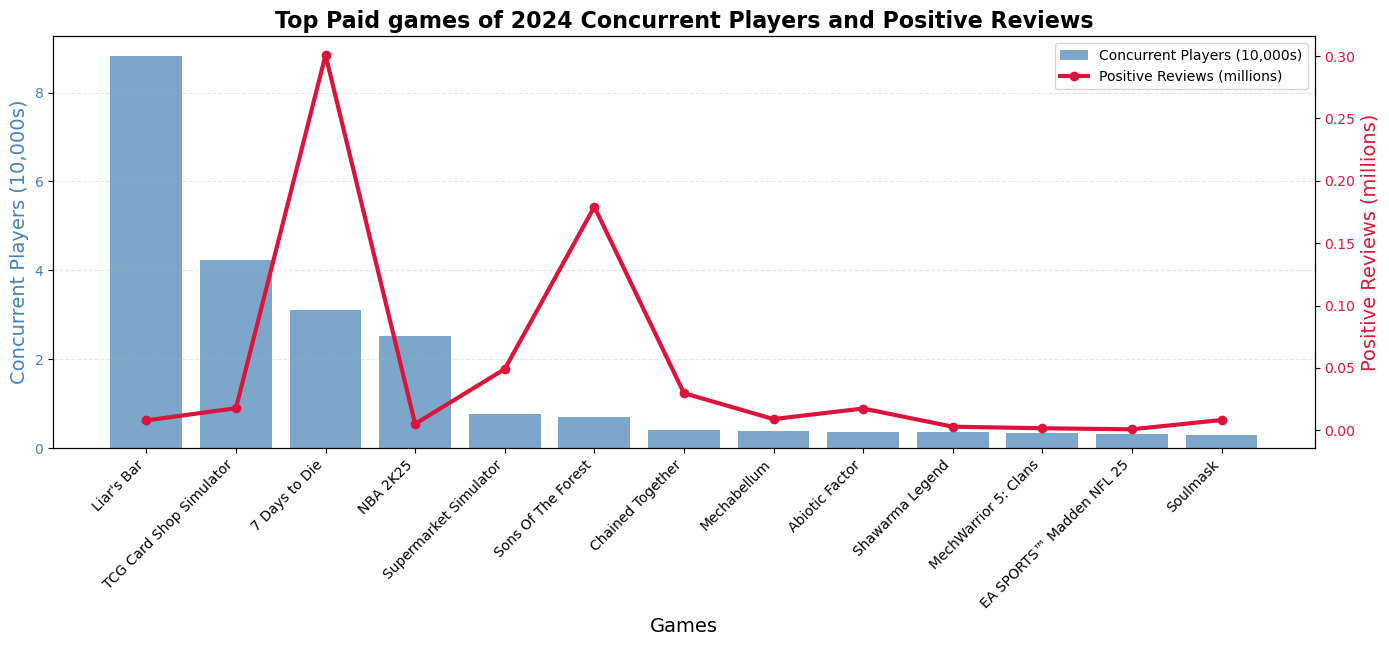

In [ ]:
# Explode the genre column from filtered_paid_games
paid_games_2018 = filtered_paid_games.explode('genre')

# Filter for games released in 2018
paid_games_2018 = paid_games_2018[paid_games_2018['release_year'] == 2024]

# Filter for only the top genres
paid_games_2018 = paid_games_2018[
                                  (paid_games_2018['genre'] == 'Simulation')]

# Re-aggregate the genres into lists by game
paid_games_2018 = paid_games_2018.groupby(['app_id', 'name','release_year', 'positive', 
                                           'concurrent_users_yesterday'])['genre'].agg(list).reset_index()

# Display the first few rows
top_paid_games_2018 = paid_games_2018.sort_values('concurrent_users_yesterday', ascending=False)
top_paid_games_2018 = top_paid_games_2018[top_paid_games_2018['concurrent_users_yesterday'] >= 2844]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Sort by concurrent players descending
top_games = top_paid_games_2018.copy()

# Convert to appropriate scales
top_games['concurrent_users_scaled'] = top_games['concurrent_users_yesterday'] / 10000
top_games['positive_millions'] = top_games['positive'] / 1000000

# Plot concurrent players as bars on the primary axis (in 10,000s)
bars = ax1.bar(range(len(top_games)), top_games['concurrent_users_scaled'], color='steelblue', alpha=0.7, label='Concurrent Players')
ax1.set_xlabel('Games', fontsize=14)
ax1.set_ylabel('Concurrent Players (10,000s)', color='steelblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Create the secondary axis for positive reviews (in millions)
ax2 = ax1.twinx()
line = ax2.plot(range(len(top_games)), top_games['positive_millions'], color='crimson', marker='o', linewidth=3, label='Positive Reviews')[0]
ax2.set_ylabel('Positive Reviews (millions)', color='crimson', fontsize=14)
ax2.tick_params(axis='y', labelcolor='crimson')

# Set the game names as x-tick labels - force 45 degree rotation
ax1.set_xticks(range(len(top_games)))
ax1.set_xticklabels(top_games['name'], rotation=45, ha='right')

# Add title and grid
plt.title('Top Paid games of 2024 Concurrent Players and Positive Reviews', fontsize=16, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend without custom lines
ax1.legend([bars, line], ['Concurrent Players (10,000s)', 'Positive Reviews (millions)'], loc='upper right')

# Add bottom padding for the rotated labels
plt.subplots_adjust(bottom=0.3)

# Apply tight layout but with specific bottom padding
fig.tight_layout(rect=[0, 0.15, 1, 0.97])

plt.show()


### Pie chart of different genres in 2024 with the highest player count 

### Exploring top free games in 2017

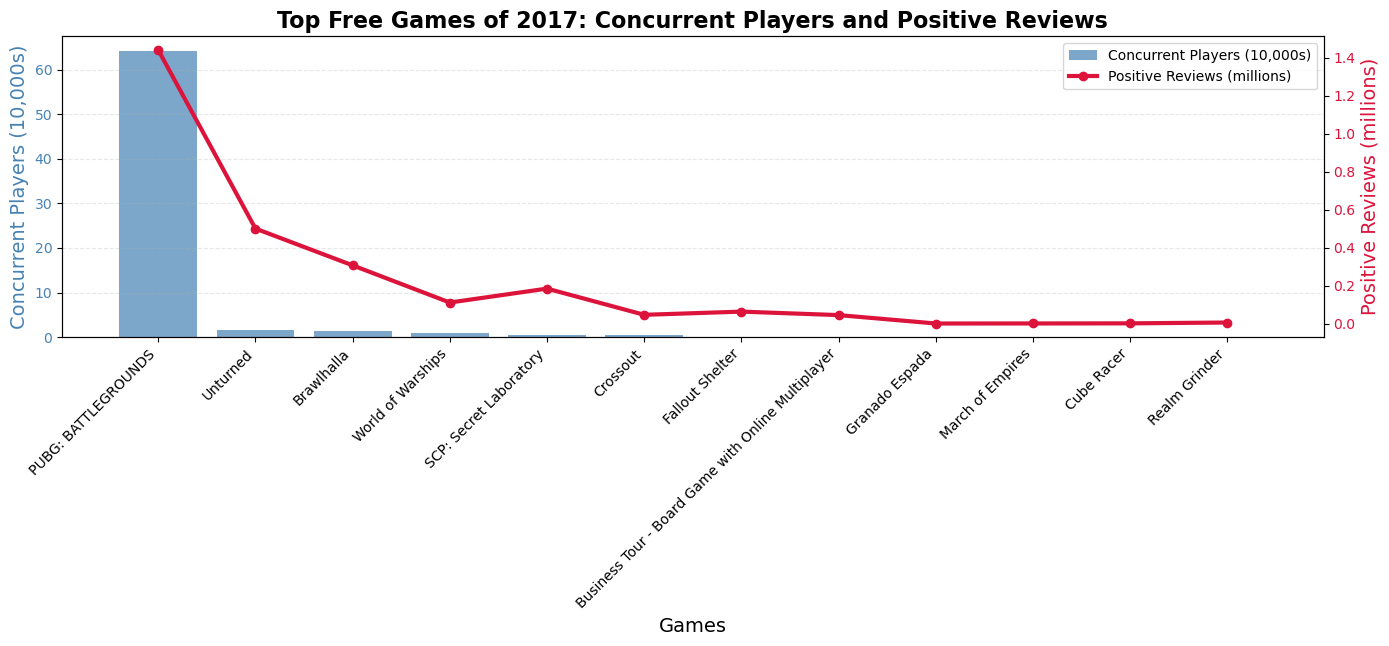

In [ ]:
# Explode the genre column from filtered_free_games
free_games_2017 = filtered_free_games.explode('genre')

# Filter for games released in 2017
free_games_2017 = free_games_2017[free_games_2017['release_year'] == 2017]

# Filter for only the top genres
free_games_2017 = free_games_2017[(free_games_2017['genre'] == 'Indie') |
                                  (free_games_2017['genre'] == 'Action') |
                                  (free_games_2017['genre'] == 'Adventure') |
                                  (free_games_2017['genre'] == 'Massively Multiplayer') |
                                  (free_games_2017['genre'] == 'RPG')]

# Re-aggregate the genres into lists by game
free_games_2017 = free_games_2017.groupby(['app_id', 'name','release_year', 'positive', 
                                           'concurrent_users_yesterday'])['genre'].agg(list).reset_index()

# Sort by concurrent players and filter for minimum threshold
top_free_games_2017 = free_games_2017.sort_values('concurrent_users_yesterday', ascending=False)
top_free_games_2017 = top_free_games_2017[top_free_games_2017['concurrent_users_yesterday'] >= 500]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Convert to appropriate scales
top_free_games_2017['concurrent_users_scaled'] = top_free_games_2017['concurrent_users_yesterday'] / 10000
top_free_games_2017['positive_millions'] = top_free_games_2017['positive'] / 1000000

# Plot concurrent players as bars on the primary axis (in 10,000s)
bars = ax1.bar(range(len(top_free_games_2017)), top_free_games_2017['concurrent_users_scaled'], 
               color='steelblue', alpha=0.7, label='Concurrent Players')
ax1.set_xlabel('Games', fontsize=14)
ax1.set_ylabel('Concurrent Players (10,000s)', color='steelblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Create the secondary axis for positive reviews (in millions)
ax2 = ax1.twinx()
line = ax2.plot(range(len(top_free_games_2017)), top_free_games_2017['positive_millions'], 
                color='crimson', marker='o', linewidth=3, label='Positive Reviews')[0]
ax2.set_ylabel('Positive Reviews (millions)', color='crimson', fontsize=14)
ax2.tick_params(axis='y', labelcolor='crimson')

# Set the game names as x-tick labels with 45-degree rotation
ax1.set_xticks(range(len(top_free_games_2017)))
ax1.set_xticklabels(top_free_games_2017['name'], rotation=45, ha='right')

# Add title and grid
plt.title('Top Free Games of 2017: Concurrent Players and Positive Reviews', fontsize=16, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend without custom lines
ax1.legend([bars, line], ['Concurrent Players (10,000s)', 'Positive Reviews (millions)'], loc='upper right')

# Add bottom padding for the rotated labels
plt.subplots_adjust(bottom=0.3)

# Apply tight layout but with specific bottom padding
fig.tight_layout(rect=[0, 0.15, 1, 0.97])

plt.show()

- Rust is the genre defining game of paid games in 2018
  - Filtered by the top genres of the year 
- PUBG is the genre defining game of free games in 2017 
  - Filtered by the top genres of the year 

### Linear Regression

### K-Nearest 

### Neural Network

<Axes: >

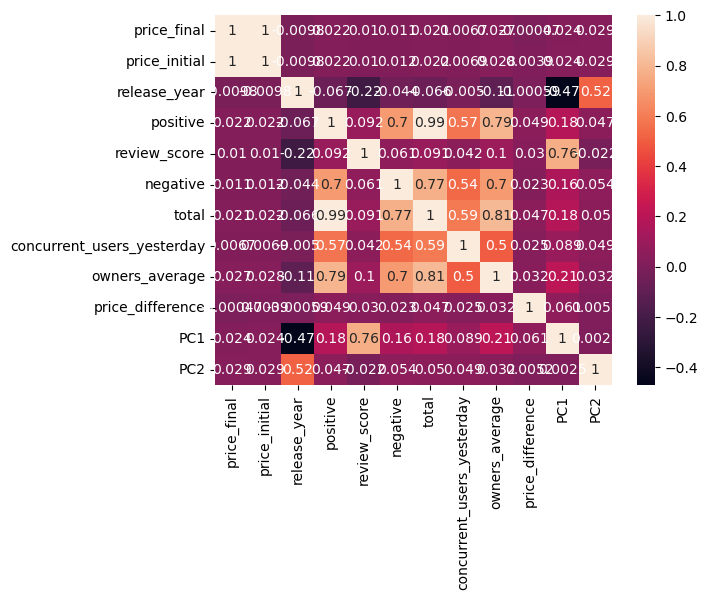

In [ ]:
# Integer values to pass into the neural network 
neural_data = pca_paid_games[['app_id','price_final', 'price_initial', 'release_year', 'positive', 'review_score', 'negative', 'total', 'concurrent_users_yesterday', 'owners_average', 'price_difference', 'PC1', 'PC2']]


# Keep app_id separate before scaling
train_app_ids = neural_data['app_id'].sample(frac=0.75, random_state=4)
train_indices = train_app_ids.index

# Features for neural network (excluding app_id)
features = ['price_final', 'price_initial', 'release_year', 'positive', 
           'review_score', 'negative', 'total', 'concurrent_users_yesterday', 
           'owners_average', 'price_difference', 'PC1', 'PC2']

# Create train and validation datasets
train_df = neural_data.loc[train_indices, features]
val_df = neural_data.loc[~neural_data.index.isin(train_indices), features]

# Keep track of app_ids separately
train_ids = neural_data.loc[train_indices, 'app_id']
val_ids = neural_data.loc[~neural_data.index.isin(train_indices), 'app_id']

# Scale the data between (0,1)
max_val = train_df.max(axis=0)
min_val = train_df.min(axis=0)
range_val = max_val - min_val
train_df_scaled = (train_df - min_val) / range_val
val_df_scaled = (val_df - min_val) / range_val


'''# Defining training and target variables 
input_features = ['price_final', 'price_initial', 'release_year', 'positive', 
                 'review_score', 'negative', 'total', 'concurrent_users_yesterday', 
                 'owners_average', 'price_difference', 'PC2']
target_feature'''
